In [188]:
%matplotlib inline

from __future__ import division, print_function
import numpy as np
import random
from astropy.table import Table
import matplotlib.pyplot as plt
import fitsio
from astropy.io import fits
import healpy as hp
from scipy.interpolate import interp1d
import sys, os, warnings
from astropy.coordinates import SkyCoord


sys.path.append(os.path.expanduser("~")+'/DESI/matches/')
from main_def import cut, flux_to_mag
from main_def_2 import relative_density_plot, circular_mask_radii_func, search_around, make_cutout_table
from main_def_2 import overdensity, extract_annulus, flux_to_mag, get_mag_decals, scatter_plot
from main_def_2 import make_plot_zoom, make_plot_zoom_comp

from kdcount import KDTree
from veto import veto, veto_ellip, match

from astropy import units as u

In [3]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

## Loading catalogues and Randoms

In [4]:
#Loading BGS_SV catalogues for 1400 s.q.d footprint with Quality Cuts (QCs) applied (cat) and without QCs (catr)
catr = Table.read('catr.fits')
cat = Table.read('cat.fits')

In [5]:
#Loading Tycho2 catalogue
path = '/global/homes/q/qmxp55/DESI/matches/'
tycho = Table.read(path+'tycho2.fits')

In [6]:
#Reducing footprint of catalogues to match the BGS footprint of 1400 s.q.d plus delta for each side

delta = 240/3600.
print(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, catr['DEC'].max()+delta)

tycho_S = cut(catr['RA'].min()-delta, catr['RA'].max()+delta, catr['DEC'].min()-delta, 
                catr['DEC'].max()+delta, tycho)

159.933333538 230.06665563 -2.06666249157 18.0666647052


In [7]:
ran = '/global/homes/q/qmxp55/DESI/matches/caseC/random_1400.fits'
ran = Table.read(ran)

In [8]:
def find_nearest(array, value):
    n = [abs(i-value) for i in array]
    idx = n.index(min(n))
    return idx

In [169]:
def interp(eta2d, var, invert=False):
    
    x, y = eta2d #np.transpose(eta2d)
    
    if invert:
        interp = interp1d(y, x, bounds_error=False, fill_value=(x[0], x[-1]))
        if var > y[-1]:
            return 0
        else:
            return interp(var)
    else:
        interp = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))
        return interp(var)
    

In [530]:
def n_density(cat1, A):
    '''
    Get the cumulative number density
    
    Inputs
    ------
    cat: (ND-array) catalogue
    catR: (ND-array) Random catalogue
    A: (integer) Area of cat and catR in s.q.d
    
    Outputs
    -------
    eta: (2D-array) MAG, Density
    '''
    
    #g, r, z, w1, G, rr = get_mag_decals(cat)
    r = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    #etaR = 13792640./A
    fR = 1.003
    eta = []
    mag = np.linspace(19.0, 21, 50)
    #Nran = len(catR)
    
    for i in range(len(mag)):
        
        N = len(cat1[r < mag[i]])
        #eta.append([mag[i], etaR*(N/Nran)])
        eta.append([mag[i], fR*N/A])
            
    eta = np.array(eta).transpose()
    print('DONE...')
    
    return eta

In [174]:
def fiberflux(cat1, col1, col2, A, title, fixed=False):
    
    mag1 = flux_to_mag(cat1[col1]/cat1['MW_TRANSMISSION_R'])
    mag2 = flux_to_mag(cat1[col2])
    
    fig = plt.figure(figsize=(8, 8))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    #axScatter2 = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    

    #axScatter.plot(d_ra, d_dec, 'k.', markersize=markersize, alpha=alpha)
    pos = axScatter.hexbin(mag1, mag2, gridsize=(60,60), cmap='viridis', bins='log', mincnt=1,label=r'test', alpha=0.8)
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(N)$')
    #axScatter.scatter(mag1, mag2, s=0.1)
    axScatter.set_ylabel(r'$22.5 - 2.5\times \log_{10}$(%s)' %(col2))
    #axScatter.set_xlabel(r'$22.5 - 2.5\times \log_{10}$(%s)' %(col1))
    axScatter.set_xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %(col1, 'MW_TRANSMISSION_R'))
    axScatter.grid()

    weights1 = np.zeros_like(mag1) + 1/1400.
    
    N1 = axHistx.hist(mag1, bins=70, cumulative=True, histtype='step', align='mid', weights=weights1, color='r', linewidth=2)
    N2 = axHisty.hist(mag2, bins=70, cumulative=True, histtype='step', align='mid', weights=weights1, color='r', linewidth=2, orientation='horizontal')
    
    #get the mag from the number density for var 1
    eta_1 = n_density(cat1, A)
    x1, x2 = interp(eta_1, 800, invert=True), interp(eta_1, 1400, invert=True)
    #x1, x2 = eta_1[0][find_nearest(eta_1[1], 800)], eta_1[0][find_nearest(eta_1[1], 1400)]
    
    #get the mag from the number density for var 2
    def n_density_2(cat1, catR, A):
        
        etaR = 13792640./A
        eta = []
        mag = np.linspace(20, 27.5, 100)
        Nran = len(catR)
    
        for i in range(len(mag)):
        
            N = len(mag2[mag2 < mag[i]])
            eta.append([mag[i], etaR*(N/Nran)])
            
        eta = np.array(eta).transpose()
        return eta
    
    #eta_2 = n_density_2(cat1, catR, A)
    #y1, y2 = eta_2[0][find_nearest(eta_2[1], 800)], eta_2[0][find_nearest(eta_2[1], 1400)]
    
    #axScatter.axhline(y1, color='black', linestyle='--', linewidth=1.5, label=r'$800/deg^2$')
    axScatter.axvline(x1, color='black', linestyle='--', linewidth=1.5)
    #axScatter.axhline(y2, color='orange', linestyle='--', linewidth=1.5, label=r'$1400/deg^2$')
    axScatter.axvline(x2, color='orange', linestyle='--', linewidth=1.5)
    axScatter.axvline(19.5, color='gray', linestyle='--', linewidth=1.0)
    
    
    #axScatter.axhline(N2[1][find_nearest(N2[0], 800)], color='black', linestyle='--', linewidth=1.5, label=r'$800/deg^2$')
    #axScatter.axvline(N1[1][find_nearest(N1[0], 800)], color='black', linestyle='--', linewidth=1.5)
    #print('800 p.s.q.d: x = %g, y = %g' %(x1,y1))
    
    #axScatter.axhline(N2[1][find_nearest(N2[0], 1400)], color='orange', linestyle='--', linewidth=1.5, label=r'$1400/deg^2$')
    #axScatter.axvline(N1[1][find_nearest(N1[0], 1400)], color='orange', linestyle='--', linewidth=1.5)
    #print('1400 p.s.q.d: x = %g, y = %g' %(x2,y2))
    
    print('rmag (800 sq.d)= %g, rmag (1400 sq.d)= %g' %(x1,x2))
    
    if fixed:
        
        axScatter.set_xlim(10, 21.5)
        axScatter.set_ylim(10, 30.5)
    
    axHistx.axis('off')
    axHisty.axis('off')
    
    print('---------------------')
    print('In rmag=19.5: %g' %(interp(eta_1, 19.5, invert=False)))
    print('In rmag=20: %g' %(interp(eta_1, 20, invert=False)))
    print('In rmag=20.1: %g' %(interp(eta_1, 20.1, invert=False)))
    print('In rmag=20.2: %g' %(interp(eta_1, 20.2, invert=False)))
    print('In rmag=20.5: %g' %(interp(eta_1, 20.5, invert=False)))
    
    #print(len(mag1[mag1 < 19.39]), len(mag2[mag2 < 20.7]))
    
    #lgnd = axScatter.legend()
    #for handle in lgnd.legendHandles:
    #    handle.set_sizes([10.0])

## FIBERFLUX Vs Total MAG test

Below plot shows $22.5 - 2.5\times \log_{10}$(FLUX_R/MW_TRANSMISSION_R) Vs $22.5 - 2.5\times \log_{10}$(FIBERFLUX_R)for BGS sample of ~ 1400 sq.d after the quality cuts (AQCs). The color indicate the Number of BGS objects per hexbin. Red curves are the cumulative distribution of their respectives axes and black and orange dashed lines represent the limits for 800 objects/deg$^2$ and 1400 objects/deg$^2$ respectively.

To get the number density I divide over the 1400 sq. deg. Doing it in the right way $\eta = N/A \times f_R$ where $f_R = N_R/N_{R}^{mask} \sim 13792640/13740085=1.003$ this means adding the mask to the randoms (which are only for NOBS) to get the number density only accounts for $\sim 0.3 \%$.  

DONE...
rmag (800 sq.d)= 19.416, rmag (1400 sq.d)= 19.9601
---------------------
In rmag=19.5: 873.187
In rmag=20: 1457.22
In rmag=20.1: 1610.2
In rmag=20.2: 1778.18
In rmag=20.5: 2385.9


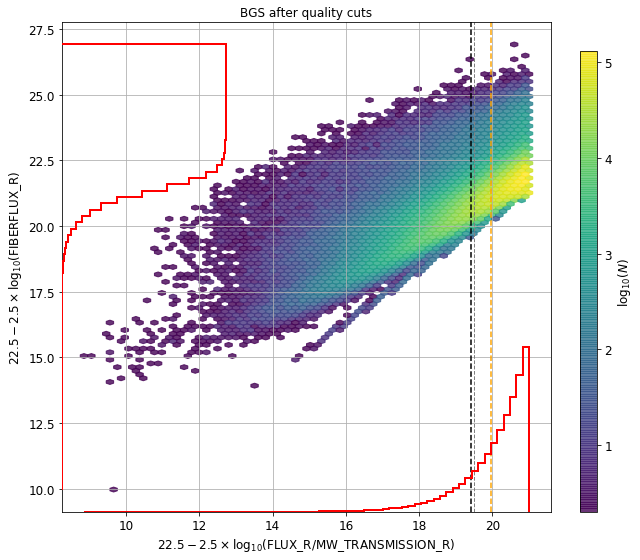

In [175]:
#mask_nobs = (ran['NOBS_G'] > 0) & (ran['NOBS_R'] > 0) & (ran['NOBS_Z'] > 0)
fiberflux(cat, 'FLUX_R', 'FIBERFLUX_R', 1400, 'BGS after quality cuts', fixed=False)

DONE...
rmag (800 sq.d)= 19.416, rmag (1400 sq.d)= 20.2151
---------------------
In rmag=19.5: 872.102
In rmag=20: 1251.39
In rmag=20.1: 1323.74
In rmag=20.2: 1390.62
In rmag=20.5: 1538.27


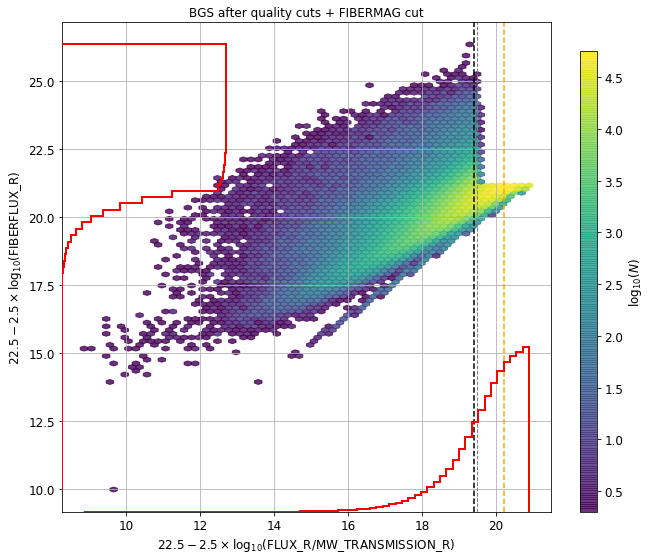

In [407]:
del mask_fiber
rmag = flux_to_mag(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
fibmag = flux_to_mag(cat['FIBERFLUX_R'])
#masking to select only objects with FIBERMAG below 21.2 but only for rmag > 19.5. This selects the Brightest 
#in FIBERMAG for the faintest sample of BGS.
mask_fiber = (fibmag > 21.2) & (rmag > 19.5)

fiberflux(cat[~mask_fiber], 'FLUX_R', 'FIBERFLUX_R', 1400, 'BGS after quality cuts + FIBERMAG cut', fixed=False)

In [133]:
#weights = np.zeros_like(fibmag) + 1/1400.
#plt.hist(fibmag, bins=70, cumulative=True, histtype='step', align='mid', weights=weights, color='r', linewidth=2)
mask_bgsfaint = rmag > 19.5
mask_fiber1 = (fibmag < 21.5) & (rmag > 19.5)
mask_fiber2 = (fibmag < 22.5) & (rmag > 19.5)
mask_fiber3 = (fibmag < 23.5) & (rmag > 19.5)
mask_fiber4 = (fibmag < 24.5) & (rmag > 19.5)
mask_fiber5 = (fibmag < 25.5) & (rmag > 19.5)
eta = n_density(cat[mask_bgsfaint], 1400)
eta1 = n_density(cat[mask_fiber1], 1400)
eta2 = n_density(cat[mask_fiber2], 1400)
eta3 = n_density(cat[mask_fiber3], 1400)
eta4 = n_density(cat[mask_fiber4], 1400)
eta5 = n_density(cat[mask_fiber5], 1400)

DONE...
DONE...
DONE...
DONE...


In [137]:
mask_fiber0 = (fibmag < 21.0) & (rmag > 19.5)
eta0 = n_density(cat[mask_fiber0], 1400)

DONE...


In [142]:
mask_fiber01 = (fibmag < 21.1) & (rmag > 19.5)
eta01 = n_density(cat[mask_fiber01], 1400)

mask_fiber02 = (fibmag < 21.2) & (rmag > 19.5)
eta02 = n_density(cat[mask_fiber02], 1400)

DONE...
DONE...


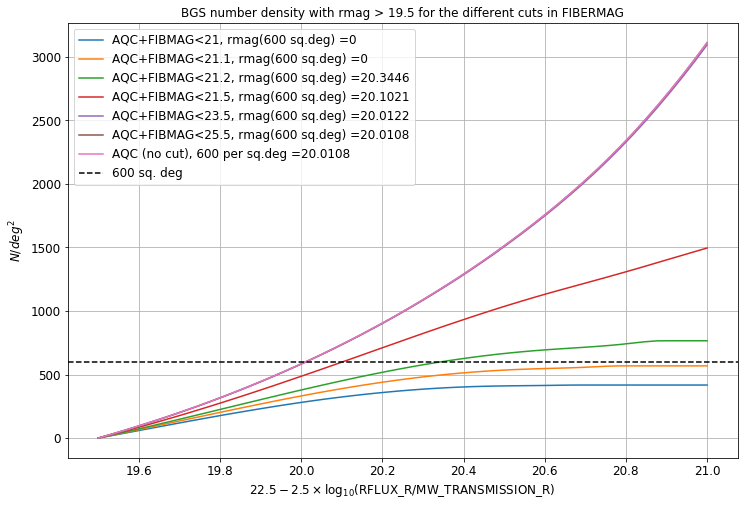

In [408]:
plt.figure(figsize=(12, 8))

plt.plot(eta0[0], eta0[1], label='AQC+FIBMAG<21, rmag(600 sq.deg) =%g' %(interp(eta0, 600, invert=True)))
plt.plot(eta01[0], eta01[1], label='AQC+FIBMAG<21.1, rmag(600 sq.deg) =%g' %(interp(eta01, 600, invert=True)))
plt.plot(eta02[0], eta02[1], label='AQC+FIBMAG<21.2, rmag(600 sq.deg) =%g' %(interp(eta02, 600, invert=True)))

plt.plot(eta1[0], eta1[1], label='AQC+FIBMAG<21.5, rmag(600 sq.deg) =%g' %(interp(eta1, 600, invert=True)))
#plt.plot(eta2[0], eta2[1], label='AQC+FIBMAG<22.5, rmag(600 sq.deg) =%g' %(interp(eta2, 600, invert=True)))
plt.plot(eta3[0], eta3[1], label='AQC+FIBMAG<23.5, rmag(600 sq.deg) =%g' %(interp(eta3, 600, invert=True)))
#plt.plot(eta4[0], eta4[1], label='AQC+FIBMAG<24.5, rmag(600 sq.deg) =%g' %(interp(eta4, 600, invert=True)))
plt.plot(eta5[0], eta5[1], label='AQC+FIBMAG<25.5, rmag(600 sq.deg) =%g' %(interp(eta5, 600, invert=True)))

plt.plot(eta[0], eta[1], label='AQC (no cut), 600 per sq.deg =%g' %(interp(eta, 600, invert=True)))

         
plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'))
plt.ylabel(r'$N/deg^2$')
plt.title(r'BGS number density with rmag > 19.5 for the different cuts in FIBERMAG')
plt.axhline(600, c='k', ls='--', label=r'600 sq. deg')
#plt.axhline(700, c='blue', ls='--', label=r'700 sq. deg')
plt.legend()
plt.grid()
plt.show()

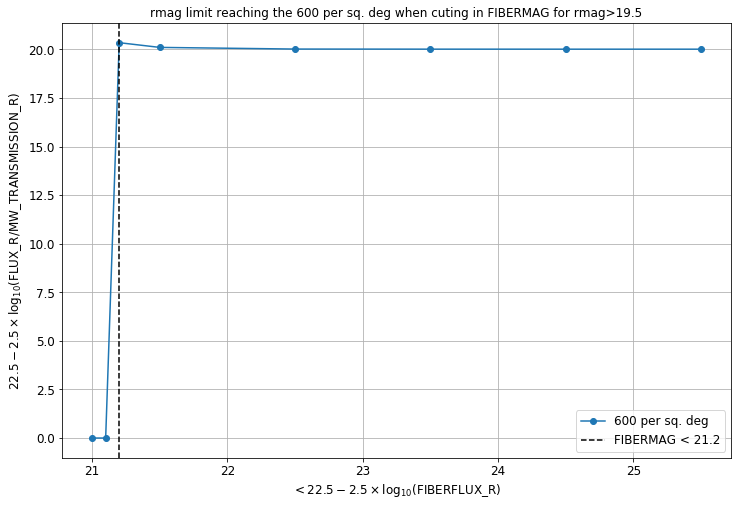

In [161]:
plt.figure(figsize=(12, 8))

xfib = [21, 21.1, 21.2, 21.5, 22.5, 23.5, 24.5, 25.5]
yfib = [interp(eta0, 600, invert=True), interp(eta01, 600, invert=True), interp(eta02, 600, invert=True),
       interp(eta1, 600, invert=True), interp(eta2, 600, invert=True), interp(eta3, 600, invert=True),
       interp(eta4, 600, invert=True), interp(eta5, 600, invert=True)]

#plt.plot(eta_fib[0], eta_fib[1], marker='o', label='600 per sq. deg')
plt.plot(xfib, yfib, marker='o', label='600 per sq. deg')

plt.title(r'rmag limit reaching the 600 per sq. deg when cuting in FIBERMAG for rmag>19.5')
plt.xlabel(r'$< 22.5 - 2.5\times \log_{10}$(%s)' %('FIBERFLUX_R'))
plt.ylabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('FLUX_R', 'MW_TRANSMISSION_R'))
plt.axvline(21.2, c='k', ls='--', label=r'FIBERMAG < 21.2')
plt.legend()
#plt.xlim(19.5, 21.5)
plt.grid()
plt.show()

## Rongpu's mask for BGS

In [362]:
def circular_mask_radii_func(MAG, radii_1):
    '''
    Define mask radius as a function of the magnitude

    Inputs
    ------
    magnitude: Magnitude in (array);

    Output
    ------
    radii: mask radii (array)
    '''
    #add the data to interpolate in format ['MAG', DISTANCE (arcsec)]
    #For LSLGA
    #x, y = np.transpose([[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]])
    #For TWOMASS
    #x, y = np.transpose([[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], [14.5, 20], [15.5, 10], [16.5, 5]])
    x, y = np.transpose(radii_1)
    circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))

    #MAG = np.array(MAG)
    #radii = np.zeros(len(MAG))
    #mask = MAG>10 # set maximum mask radius
    #if np.sum(mask)>0:
    #    radii[mask] = circular_mask_radii_func(MAG[mask]) #pa*(w1_ab[mask])**3 + pb*(w1_ab[mask])**2 +pc*(w1_ab[mask]) + pd
    #if np.sum(~mask)>0:
    #    radii[~mask] = 100

    # mask radius in arcsec
    return circular_mask_radii_func(MAG)

In [373]:
#Rongpu's circ radii
rongpuLRG_radii = [[4.0, 210.],[4.5, 210.], [5.5, 200.], [6.25, 150.], [6.75, 125.],
                   [7.25, 120.], [7.75, 110.], [8.25, 100.], [8.75,  75.], [9.25,  60.],
                   [9.75,  55.], [ 10.25,  50.], [ 10.75,  48.], [ 11.25,  40.], [ 11.75,  37.], 
                   [ 12.25,  25.], [ 12.75,  20.], [ 13.25,  18.], [ 13.75,  16.], [ 14.25,  12.], 
                   [ 14.75,  11.], [ 15.25,  11.], [ 15.75,  10.]]

#Rongpu's length radii (diff spikes)
rongpuLRG_length_radii = [[4.0, 600.], [4.5, 600.], [5.5, 600.], [6.25, 540.], [6.75, 520.], [7.25, 500.], 
                   [7.75, 320.], [8.25, 300.], [8.75, 290.], [9.25, 160.], [9.75, 150.], [ 10.25, 140.],
                   [ 10.75, 130.], [ 11.25, 130.], [ 11.75, 100.], [ 12.25, 60.], [ 12.75, 40.], [ 13., 40.]]

#Rongpu's widht radii (diff spikes)
rongpuLRG_widht_radii = [[8., 25.], [13., 16.]]

#kyle_radii's = rongpuLRG_radii's/np.sqrt(2)
kyle_radii = []
for i in range(len(rongpuLRG_radii)):
    kyle_radii.append([rongpuLRG_radii[i][0], rongpuLRG_radii[i][1]/np.sqrt(2)])

kyle_length_radii = []
for i in range(len(rongpuLRG_length_radii)):
    kyle_length_radii.append([rongpuLRG_length_radii[i][0], rongpuLRG_length_radii[i][1]/np.sqrt(2)])

kyle_widht_radii = []
for i in range(len(rongpuLRG_widht_radii)):
    kyle_widht_radii.append([rongpuLRG_widht_radii[i][0], rongpuLRG_widht_radii[i][1]/np.sqrt(2)])
    
#TWOMASS radii
twomass_radii = [[9.5,100], [10.5, 80], [11.5, 70], [12.5, 50], [13.5, 30], 
                 [14.5, 20], [15.5, 10], [16.5, 5]]

#LSLGA radii
LSLGA_radii = [[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], 
               [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]]

In [409]:
def mask_funct(radii_1, radii_2):
    
    x1, y1 = np.transpose(radii_1)
    circular_mask_radii_func1 = interp1d(x1, y1, bounds_error=False, fill_value=(y1[0], y1[-1]))
    
    x2, y2 = np.transpose(radii_2)
    circular_mask_radii_func2 = interp1d(x2, y2, bounds_error=False, fill_value=(y2[0], y2[-1]))
    
    x3, y3 = np.transpose(rongpuLRG_length_radii)
    circular_mask_radii_func3 = interp1d(x3, y3, bounds_error=False, fill_value=(y3[0], y3[-1]))
    
    x4, y4 = np.transpose(rongpuLRG_widht_radii)
    circular_mask_radii_func4 = interp1d(x4, y4, bounds_error=False, fill_value=(y4[0], y4[-1]))
    
    x5, y5 = np.transpose(kyle_length_radii)
    circular_mask_radii_func5 = interp1d(x5, y5, bounds_error=False, fill_value=(y5[0], y5[-1]))
    
    x6, y6 = np.transpose(kyle_widht_radii)
    circular_mask_radii_func6 = interp1d(x6, y6, bounds_error=False, fill_value=(y6[0], y6[-1]))
    
    plt.figure(figsize=(10,6))
    
    mag = np.linspace(4, 16, 30)
    
    plt.plot(mag, circular_mask_radii_func1(mag), marker='o', color='blue', linestyle='-', label=r'Rongpu LRG circ (W1_ab)')
    #plt.plot(mag, circular_mask_radii_func3(mag), marker='o', color='blue', linestyle='--', label=r'Rongpu LRG length')
    #plt.plot(mag, circular_mask_radii_func4(mag), marker='o', color='blue', linestyle='-.', label=r'Ronpu LRG widht')
    
    plt.plot(mag, circular_mask_radii_func2(mag), marker='o', color='orange', linestyle='--', label=r'Ronpu/$\sqrt{2}$ circ (MAG_VT)')
    #plt.plot(mag, circular_mask_radii_func5(mag), marker='o', color='orange', linestyle='--', label=r'Rongpu/$\sqrt{2}$ LRG length')
    #plt.plot(mag, circular_mask_radii_func6(mag), marker='o', color='orange', linestyle='-.', label=r'Ronpu/$\sqrt{2}$ LRG widht')
    
    plt.title(r'Mask radii for Brigh Stars')
    plt.legend()
    plt.grid()
    plt.xlabel(r'mag')
    plt.ylabel(r'r(arcsec)')
    plt.show()

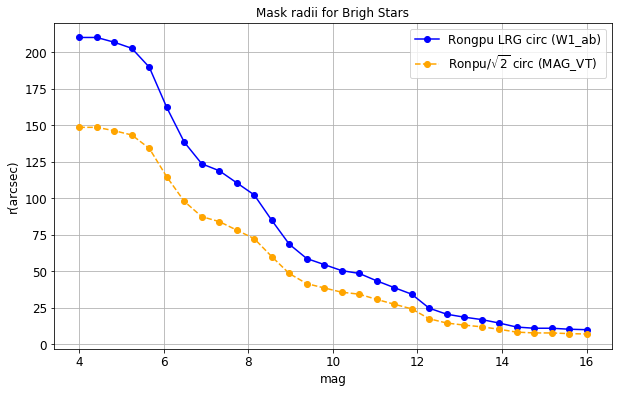

In [410]:
mask_funct(rongpuLRG_radii, kyle_radii)

In [411]:
def overdensity(cat, star, radii_1, nameMag, slitw, density=False, magbins=(8,14,4), radii_2=None):
    '''
    Get scatter and density plots of objects of cat1 around objects of cat2 within a search radius in arcsec.

    Inputs
    ------
    cat: (array) catalogue 1;
    star: (array) catalogue 2;
    nameMag: (string) label of magnitude in catalogue 2;
    slitw: (float, integer) slit widht;
    density: (boolean) True to get the density as function of distance (arcsec) within shells;
    magbins: (integers) format to separate the magnitude bins in cat2 (min, max, number bins);

    Output
    ------
    (distance (arcsec), density) if density=True
    '''
    # define the slit width for estimating the overdensity off diffraction spikes
    slit_width = slitw
    search_radius = 240.

    # Paramater for estimating the overdensities
    annulus_min = 1
    annulus_max = 240.

    ra2 = star['RA']
    dec2 = star['DEC']
    ra1 = cat['RA']
    dec1 = cat['DEC']

    if density:

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2, dec2, ra1, dec1,
                                                 search_radius=search_radius)
        density = []
        shells = np.linspace(1, search_radius, search_radius)
        for i in range(len(shells)-1):

            ntot_annulus = np.sum((d2d>shells[i]) & (d2d<shells[i+1]))
            density_annulus = ntot_annulus/(np.pi*(shells[i+1]**2 - shells[i]**2))
            bincenter = (shells[i]+shells[i+1])/2

            density.append([bincenter, density_annulus])

        density = np.array(density).transpose()
        plt.figure(figsize=(12, 8))
        plt.semilogy(density[0], density[1])
        plt.xlabel(r'r(arcsec)')
        plt.ylabel(r'N/($\pi r^2$)')
        plt.grid()
        plt.show()

        return density


    mag_bins = np.linspace(magbins[0], magbins[1], magbins[2])

    for index in range(len(mag_bins)):

        if index==0:
            mask_star = (star[nameMag]<mag_bins[index])
            title = '{} < {:.2f}'.format(nameMag,mag_bins[0], np.sum(mask_star))
        else:
            mask_star = (star[nameMag]>mag_bins[index-1]) & (star[nameMag]<mag_bins[index])
            title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index-1], nameMag, mag_bins[index], np.sum(mask_star))

        print(title)

        #get the mask radii from the mean magnitude
        mag_mean = np.mean(star[nameMag][mask_star])
        print('mag_mean', mag_mean)
        mask_radius = circular_mask_radii_func([mag_mean], radii_1)[0]
        if radii_2:
            mask_radius2 = circular_mask_radii_func([mag_mean], radii_2)[0]

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2[mask_star], dec2[mask_star], ra1, dec1,
                                                 search_radius=search_radius)

        print('%d sources ~%g %% ' %(len(ra2[mask_star]),100*len(ra2[mask_star])/len(ra2)))

        markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])
        axis = [-search_radius*1.05, search_radius*1.05, -search_radius*1.05, search_radius*1.05]
        #axScatter = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=title)

        ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
        density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))

        bins, mesh_d2d, density_ratio = relative_density_plot(d_ra, d_dec, d2d, search_radius,
                                                              ref_density=density_annulus, return_res=True,
                                                              show=False, nbins=101)

        #plt.axvline(slit_width)
        #plt.axvline(-slit_width)
        #plt.axhline(slit_width)
        #plt.axhline(-slit_width)    
        angle_array = np.linspace(0, 2*np.pi, 240)
        x = mask_radius * np.sin(angle_array)
        y = mask_radius* np.cos(angle_array)
        plt.plot(x, y, 'k', lw=1.5)
        if radii_2:
            x2 = mask_radius2 * np.sin(angle_array)
            y2 = mask_radius2 * np.cos(angle_array)
            plt.plot(x2, y2, 'k', lw=1.5, linestyle='--')
        
        plt.title(title)
        plt.show()

In [378]:
# Query the WISE catalog-based mask for LRG selection

#wise_cat_path_default = '/Users/roz18/Documents/Data/desi_lrg_selection/wisemask/w1_bright-13.3_trim_dr7_region_matched.fits'
# wise_cat_path = '/global/homes/r/rongpu/mydesi/useful/w1_bright-13.3_trim_dr7_region_matched.fits'


# Define the radius mask of the circular mask
#x, y = np.transpose(kyle_radii)
#circular_mask_radii_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], y[-1]))

# Define length for diffraction spikes mask
x, y = np.transpose(kyle_length_radii)
ds_mask_length_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], 0))


# Define width for diffraction spikes mask
x, y = np.transpose(kyle_widht_radii)
ds_mask_width_func = interp1d(x, y, bounds_error=False, fill_value=(y[0], 0))


def ds_masking_func(d_ra, d_dec, d2d, w1_ab):
    '''
    Masking function for diffraction spikes
    Inputs
    ------
    d_ra, d_dec: (array) the differences in RA and Dec (arcsec); 
    d2d: (array) angular distances (arcsec);
    w1_ab: (array) W1 magnitude in AB;
    
    Output
    ------
    ds_flag: array of mask value; True if masked (contaminated).
    '''
    
    ds_mask_widths = ds_mask_width_func(w1_ab)
    ds_mask_length = ds_mask_length_func(w1_ab)

    mask1 = d_dec > (d_ra - ds_mask_widths/np.sqrt(2))
    mask1 &= d_dec < (d_ra + ds_mask_widths/np.sqrt(2))
    mask1 &= (d_dec < -d_ra + ds_mask_length/np.sqrt(2)) & (d_dec > -d_ra - ds_mask_length/np.sqrt(2))

    mask2 = d_dec > (-d_ra - ds_mask_widths/np.sqrt(2))
    mask2 &= d_dec < (-d_ra + ds_mask_widths/np.sqrt(2))
    mask2 &= (d_dec < +d_ra + ds_mask_length/np.sqrt(2)) & (d_dec > +d_ra - ds_mask_length/np.sqrt(2))

    ds_flag = (mask1 | mask2)
    
    return ds_flag


def query_catalog_mask(ra, dec, starCat, radii, diff_spikes=True, return_diagnostics=False):
    '''
    Catalog-based WISE bright star mask.
    Input:
    ra, dec: coordinates;
    diff_spikes: apply diffraction spikes masking if True;
    return_diagnostics: return disgnostic information if True;
    Return:
    cat_flag: array of mask value; the location is masked (contaminated) if True.
    '''

    # Load trimmed WISE bright star catalog
    #if wise_cat_path is None:
    #    wise_cat_path = wise_cat_path_default
    wisecat = starCat #Table.read(wise_cat_path)

    w1_ab = np.array(wisecat['MAG_VT'])
    raW = np.array(wisecat['RA'])
    decW = np.array(wisecat['DEC'])

    # Convert to the ecliptic coordinates
    #c_decals = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    #temp = c_decals.barycentrictrueecliptic
    #decals_lon, decals_lat = np.array(c_decals.lon), np.array(c_decals.lat)
    #c_wise = SkyCoord(ra=wisecat['RA']*u.degree, dec=wisecat['DEC']*u.degree, frame='icrs')
    #temp = c_wise.barycentrictrueecliptic
    #wise_lon, wise_lat = np.array(c_wise.lon), np.array(c_wise.lat)

    w1_bins = np.arange(0, 14.1, 0.5)
    
    # only flagged by the circular mask (True if contaminated):
    circ_flag = np.zeros(len(ra), dtype=bool)
    # flagged by the diffraction spike mask but not the circular mask (True if contaminated):
    ds_flag = np.zeros(len(ra), dtype=bool)
    # flagged in the combined masks (True if contaminated):
    cat_flag = np.zeros(len(ra), dtype=bool)

    # record the magnitude of the star that causes the contamination and distance to it
    w1_source = np.zeros(len(ra), dtype=float)
    d2d_source = np.zeros(len(ra), dtype=float)

    ra2, dec2 = map(np.copy, [ra, dec])
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')

    for index in range(len(w1_bins)-1):

        mask_wise = (w1_ab>=w1_bins[index]) & (w1_ab<=w1_bins[index+1])
        print('{:.2f} < W1mag < {:.2f}   {} WISE bright stars'.format(w1_bins[index], w1_bins[index+1], np.sum(mask_wise)))

        if np.sum(mask_wise)==0:
            print()
            continue
    
        # find the maximum mask radius for the magnitude bin        
        if not diff_spikes:
            search_radius = np.max(circular_mask_radii_func(w1_ab[mask_wise], radii))
        else:
            search_radius = np.max([circular_mask_radii_func(w1_ab[mask_wise], radii), 0.5*ds_mask_length_func(w1_ab[mask_wise])])

        # Find all pairs within the search radius
        ra1, dec1 = map(np.copy, [raW[mask_wise], decW[mask_wise]])
        sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
        idx_wise, idx_decals, d2d, _ = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
        print('%d nearby objects'%len(idx_wise))
        
        # convert distances to numpy array in arcsec
        d2d = np.array(d2d.to(u.arcsec))

        d_ra = (ra2[idx_decals]-ra1[idx_wise])*3600.    # in arcsec
        d_dec = (dec2[idx_decals]-dec1[idx_wise])*3600. # in arcsec
        ##### Convert d_ra to actual arcsecs #####
        mask = d_ra > 180*3600
        d_ra[mask] = d_ra[mask] - 360.*3600
        mask = d_ra < -180*3600
        d_ra[mask] = d_ra[mask] + 360.*3600
        d_ra = d_ra * np.cos(dec1[idx_wise]/180*np.pi)
        ##########################################

        # circular mask
        mask_radii = circular_mask_radii_func(w1_ab[mask_wise][idx_wise], radii)
        # True means contaminated:
        circ_contam = d2d < mask_radii
        circ_flag[idx_decals[circ_contam]] = True

        w1_source[idx_decals[circ_contam]] = w1_ab[mask_wise][idx_wise[circ_contam]]
        d2d_source[idx_decals[circ_contam]] = d2d[circ_contam]

        if diff_spikes:

            ds_contam = ds_masking_func(d_ra, d_dec, d2d, w1_ab[mask_wise][idx_wise])
            ds_flag[idx_decals[ds_contam]] = True

            # combine the two masks
            cat_flag[idx_decals[circ_contam | ds_contam]] = True

            w1_source[idx_decals[ds_contam]] = w1_ab[mask_wise][idx_wise[ds_contam]]
            d2d_source[idx_decals[ds_contam]] = d2d[ds_contam]

            print('{} objects masked by circular mask'.format(np.sum(circ_contam)))
            print('{} additionally objects masked by diffraction spikes mask'.format(np.sum(circ_contam | ds_contam)-np.sum(circ_contam)))
            print('{} objects masked by the combined masks'.format(np.sum(circ_contam | ds_contam)))
            print()

        else:

            print('{} objects masked'.format(np.sum(circ_contam)))
            print()

    if not diff_spikes:
        cat_flag = circ_flag

    if not return_diagnostics:
        return cat_flag
    else:
        # package all the extra info
        more_info = {}
        more_info['w1_source'] = w1_source
        more_info['d2d_source'] = d2d_source
        more_info['circ_flag'] = circ_flag
        more_info['ds_flag'] = ds_flag

    return cat_flag, more_info

In [379]:
rmagr = flux_to_mag(catr['FLUX_R']/catr['MW_TRANSMISSION_R'])

In [511]:
#del cattmp
#cattmp = catr[rmagr < 20]
#tymask = tycho_S['MAG_VT'] < 14
tyFlag = query_catalog_mask(cat['RA'], cat['DEC'], tycho_S, kyle_radii, diff_spikes=True, 
                            return_diagnostics=False)

0.00 < W1mag < 0.50   79 WISE bright stars
3323 nearby objects
1583 objects masked by circular mask
109 additionally objects masked by diffraction spikes mask
1692 objects masked by the combined masks

0.50 < W1mag < 1.00   0 WISE bright stars

1.00 < W1mag < 1.50   0 WISE bright stars

1.50 < W1mag < 2.00   0 WISE bright stars

2.00 < W1mag < 2.50   1 WISE bright stars
0 nearby objects
0 objects masked by circular mask
0 additionally objects masked by diffraction spikes mask
0 objects masked by the combined masks

2.50 < W1mag < 3.00   1 WISE bright stars
13 nearby objects
0 objects masked by circular mask
0 additionally objects masked by diffraction spikes mask
0 objects masked by the combined masks

3.00 < W1mag < 3.50   3 WISE bright stars
35 nearby objects
1 objects masked by circular mask
3 additionally objects masked by diffraction spikes mask
4 objects masked by the combined masks

3.50 < W1mag < 4.00   5 WISE bright stars
76 nearby objects
3 objects masked by circular mask
3 a

MAG_VT < 8.00
mag_mean 6.44833
127084 nearby objects ~ 2.10153 %
924 sources ~2.8163 % 


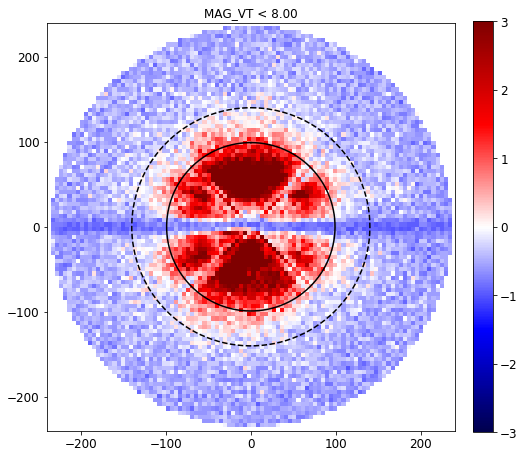

8.00 < MAG_VT < 10.00
mag_mean 9.27083
300461 nearby objects ~ 4.9686 %
4707 sources ~14.3467 % 


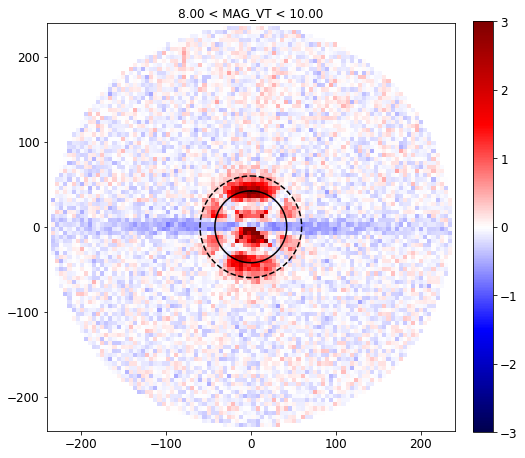

10.00 < MAG_VT < 12.00
mag_mean 11.1765
1274614 nearby objects ~ 21.0778 %
21235 sources ~64.7231 % 


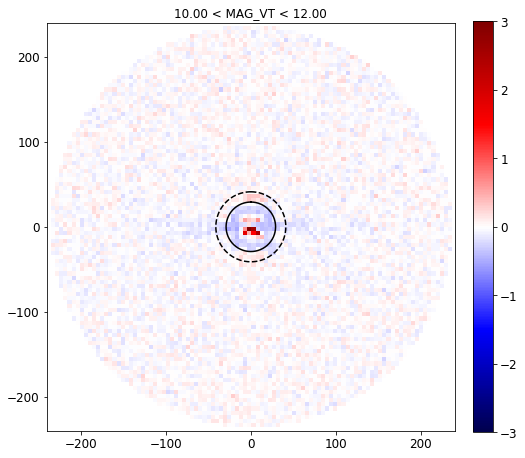

12.00 < MAG_VT < 14.00
mag_mean 12.3263
353293 nearby objects ~ 5.84226 %
5922 sources ~18.0499 % 


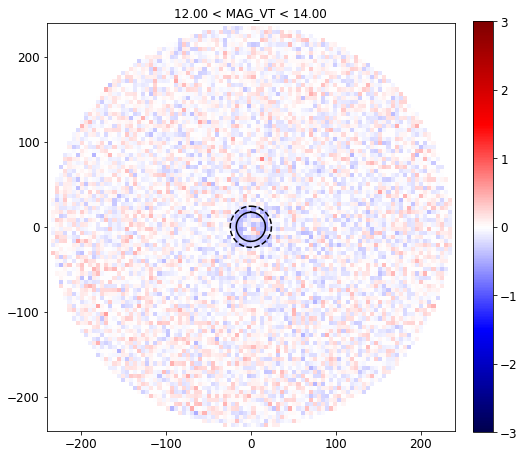

In [412]:
den_tycho_catr = overdensity(catr, tycho_S, kyle_radii, 'MAG_VT', 35, density=False, 
                            magbins=(8,14,4), radii_2=rongpuLRG_radii)

MAG_VT < 8.00
mag_mean 6.44833
49757 nearby objects ~ 0.894441 %
924 sources ~2.8163 % 


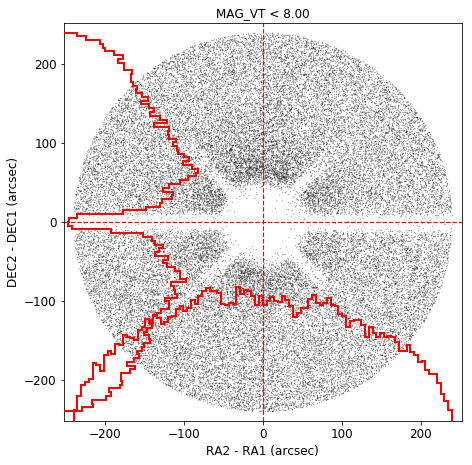

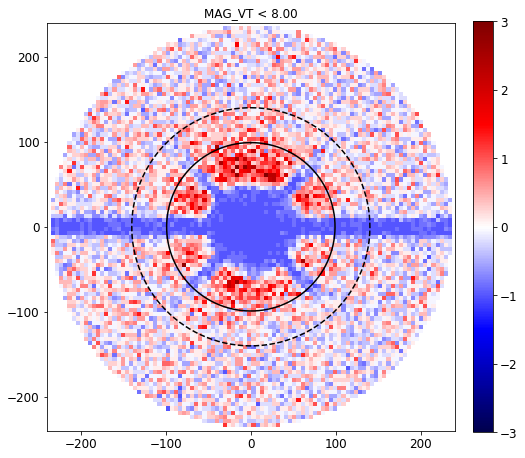

8.00 < MAG_VT < 10.00
mag_mean 9.27083
245202 nearby objects ~ 4.4078 %
4707 sources ~14.3467 % 


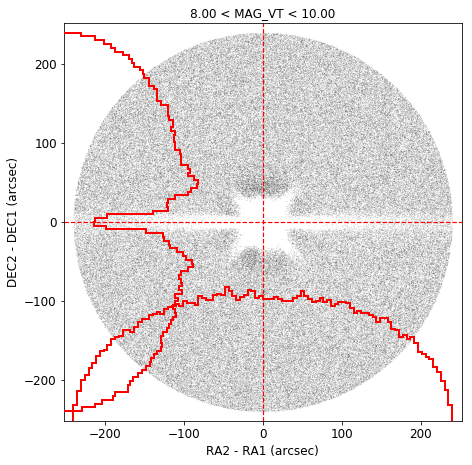

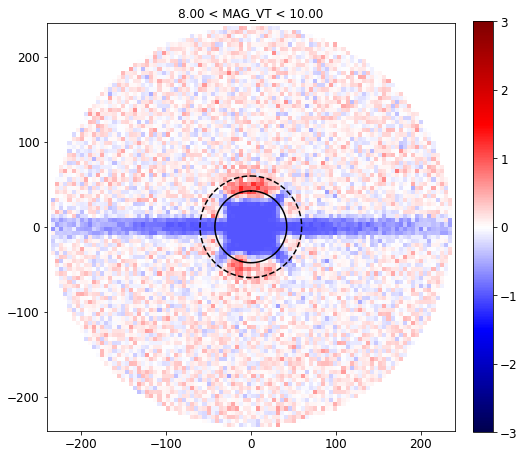

10.00 < MAG_VT < 12.00
mag_mean 11.1765
1152437 nearby objects ~ 20.7164 %
21235 sources ~64.7231 % 


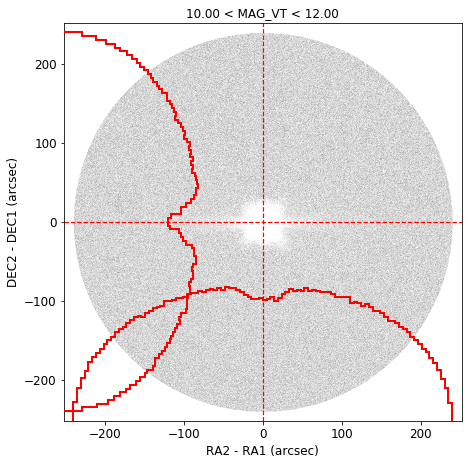

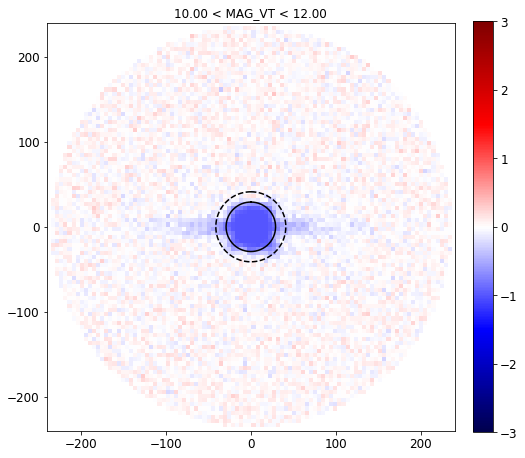

12.00 < MAG_VT < 14.00
mag_mean 12.3263
325840 nearby objects ~ 5.85736 %
5922 sources ~18.0499 % 


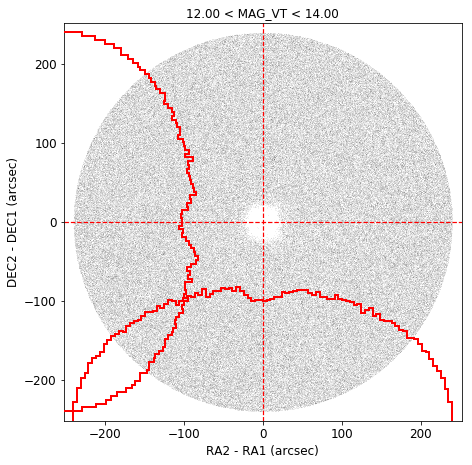

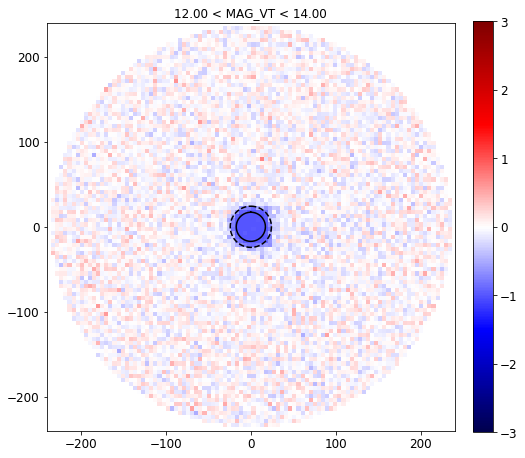

In [386]:
den_tycho_cat = overdensity(cat, tycho_S, kyle_radii, 'MAG_VT', 35, density=False, 
                            magbins=(8,14,4), radii_2=rongpuLRG_radii)

MAG_VT < 8.00
mag_mean 6.44833
55284 nearby objects ~ 0.931953 %
924 sources ~2.8163 % 


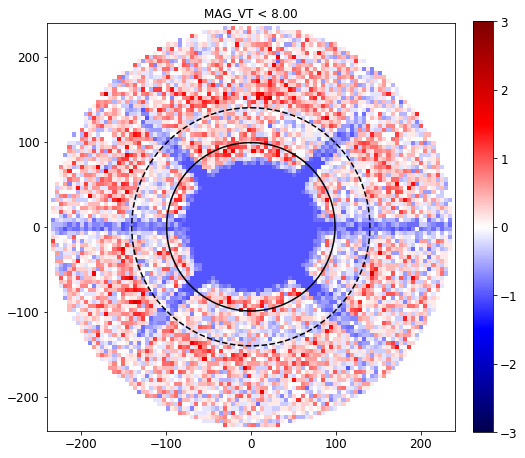

8.00 < MAG_VT < 10.00
mag_mean 9.27083
266251 nearby objects ~ 4.48834 %
4707 sources ~14.3467 % 


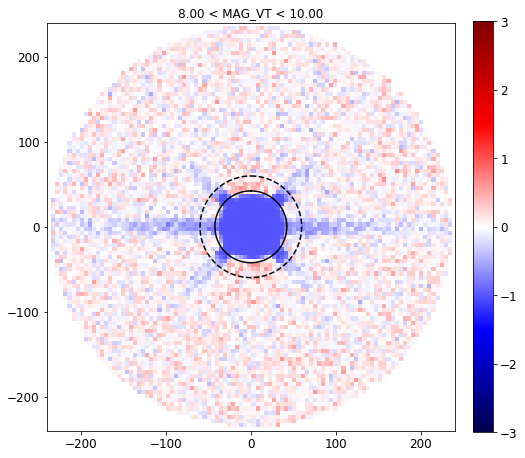

10.00 < MAG_VT < 12.00
mag_mean 11.1765
1228392 nearby objects ~ 20.7077 %
21235 sources ~64.7231 % 


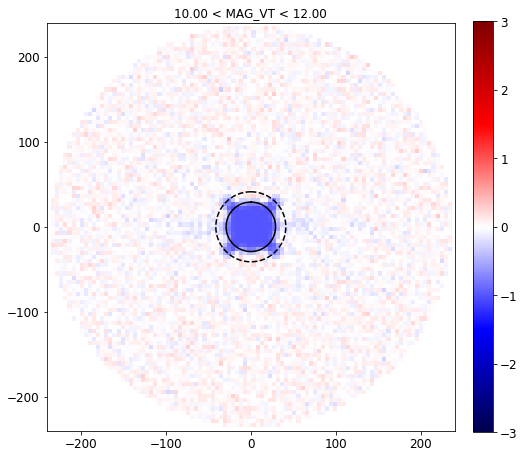

12.00 < MAG_VT < 14.00
mag_mean 12.3263
347270 nearby objects ~ 5.85412 %
5922 sources ~18.0499 % 


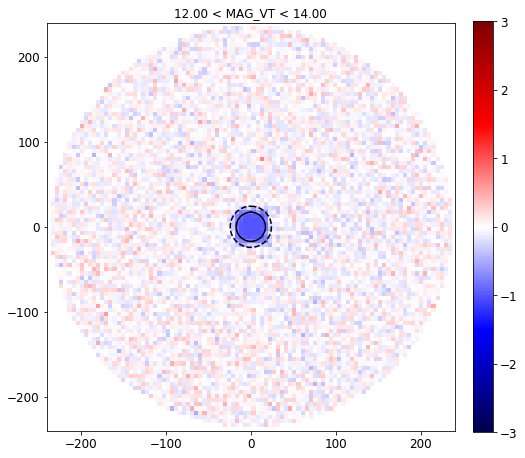

In [413]:
den_tycho_cat2 = overdensity(catr[~tyFlag], tycho_S, kyle_radii, 'MAG_VT', 35, density=False, 
                            magbins=(8,14,4), radii_2=rongpuLRG_radii)

With Rongpu's mask taking the radii's as Kyle suggested $1/\sqrt{2}$ we are only rejecting $\sim 0.35 \%$ of BGS after quality cuts.

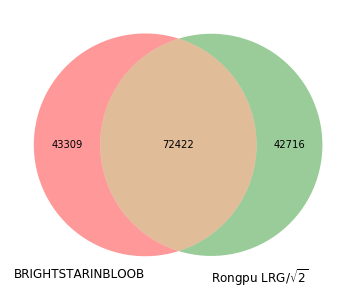

In [400]:
from matplotlib_venn import venn2, venn2_circles
plt.figure(figsize=(6, 6))

mask1 = ~catr['VETO_BRIGHTSTAR']

venn2([set(catr['RA'][mask1]), set(catr['RA'][tyFlag])], set_labels = ('BRIGHTSTARINBLOOB', r'Rongpu LRG$/\sqrt{2}$'))

In [405]:
def get_postages(CAT, N, M):
    
    import random
    n = N   #rows
    m = M   #columns
    table = (n,m)
    
    rMag = flux_to_mag(CAT['FLUX_R']/CAT['MW_TRANSMISSION_R'])
    RA, DEC = CAT['RA'], CAT['DEC']

    ranSelect = random.sample(range(len(RA)), n*m)

    make_cutout_table(RA[ranSelect], DEC[ranSelect], rMag[ranSelect], 'r', table, False, boxsize=20, 
                  layer='decals-dr7', layer2=None, savefile=None)

    make_cutout_table(RA[ranSelect], DEC[ranSelect], rMag[ranSelect], 'r', table, False, boxsize=20, 
                  layer='decals-dr7-model', layer2=None, savefile=None)


pixels: 76
pixels: 76


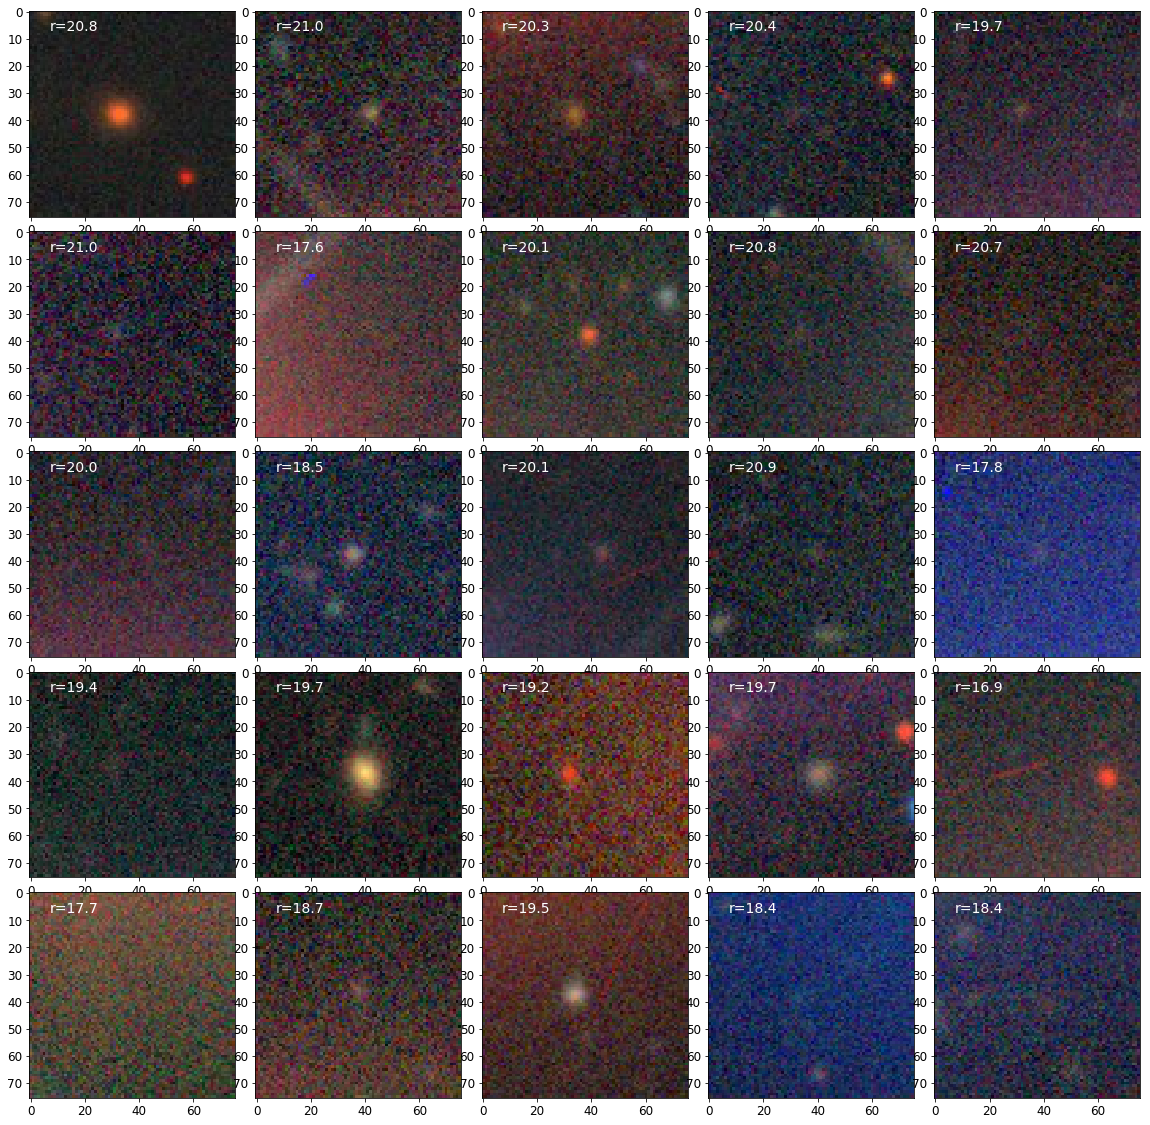

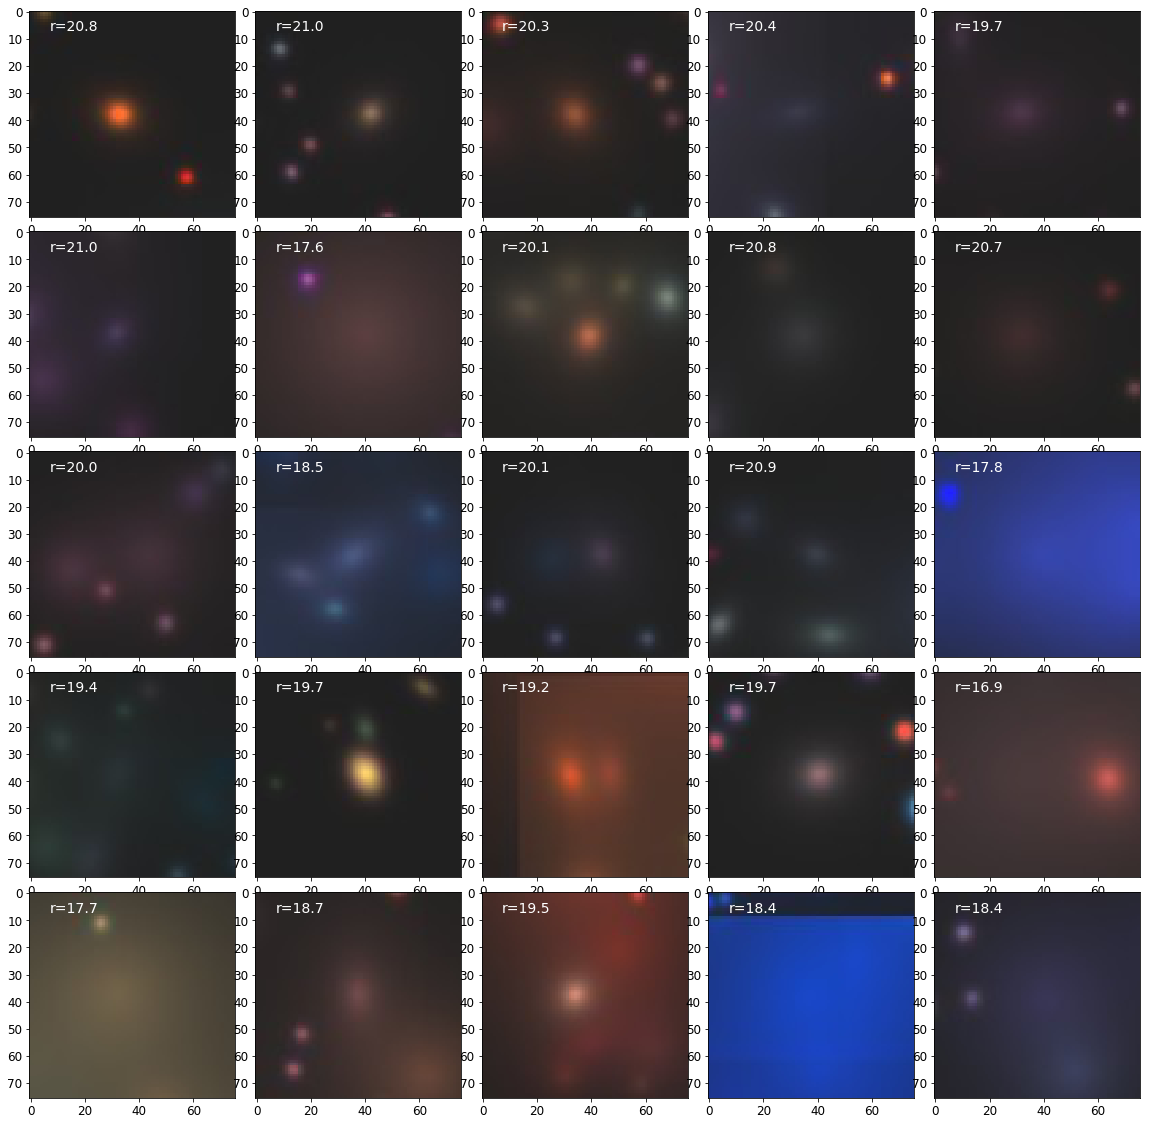

In [406]:
get_postages(catr[(tyFlag) & (~mask1)], 5, 5) 

## FIBERFLUX Vs Total MAG + Rongpu's mask

In [419]:
mask_bgsfaint_R = (rmag > 19.5) & (~tyFlag)

mask_fiber0_R = (fibmag < 21.0) & (rmag > 19.5) & (~tyFlag)
mask_fiber01_R = (fibmag < 21.1) & (rmag > 19.5) & (~tyFlag)
mask_fiber02_R = (fibmag < 21.2) & (rmag > 19.5) & (~tyFlag)
mask_fiber1_R = (fibmag < 21.5) & (rmag > 19.5) & (~tyFlag)
#mask_fiber2_R = (fibmag < 22.5) & (rmag > 19.5)
#mask_fiber3_R = (fibmag < 23.5) & (rmag > 19.5)
#mask_fiber4_R = (fibmag < 24.5) & (rmag > 19.5)
mask_fiber5_R = (fibmag < 25.5) & (rmag > 19.5) & (~tyFlag)

eta_R = n_density(cat[mask_bgsfaint_R], 1400)
eta0_R = n_density(cat[mask_fiber0_R], 1400)
eta01_R = n_density(cat[mask_fiber01_R], 1400)
eta02_R = n_density(cat[mask_fiber02_R], 1400)
eta1_R = n_density(cat[mask_fiber1_R], 1400)
#eta2 = n_density(cat[mask_fiber2], 1400)
#eta3 = n_density(cat[mask_fiber3], 1400)
#eta4 = n_density(cat[mask_fiber4], 1400)
eta5_R = n_density(cat[mask_fiber5_R], 1400)

DONE...
DONE...
DONE...
DONE...
DONE...
DONE...


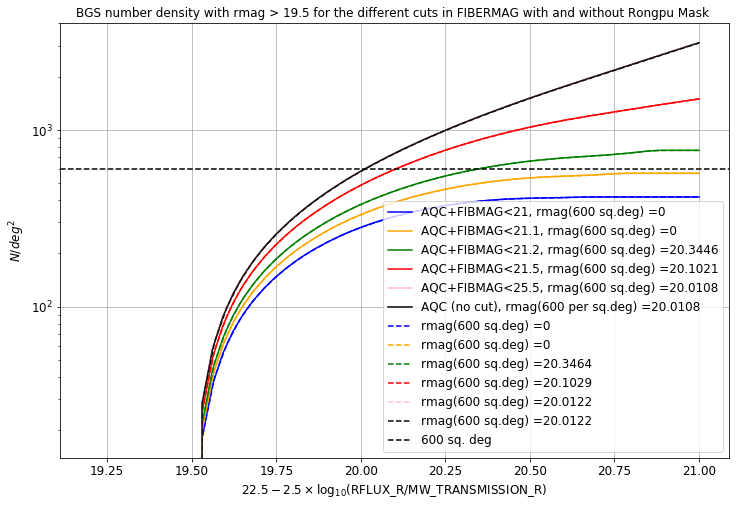

In [429]:
plt.figure(figsize=(12, 8))

# AQC r>19.5
plt.semilogy(eta0[0], eta0[1], color='blue',label='AQC+FIBMAG<21, rmag(600 sq.deg) =%g' %(interp(eta0, 600, invert=True)))
plt.semilogy(eta01[0], eta01[1], color='orange',label='AQC+FIBMAG<21.1, rmag(600 sq.deg) =%g' %(interp(eta01, 600, invert=True)))
plt.semilogy(eta02[0], eta02[1], color='green',label='AQC+FIBMAG<21.2, rmag(600 sq.deg) =%g' %(interp(eta02, 600, invert=True)))
plt.semilogy(eta1[0], eta1[1], color='red',label='AQC+FIBMAG<21.5, rmag(600 sq.deg) =%g' %(interp(eta1, 600, invert=True)))
plt.semilogy(eta5[0], eta5[1], color='pink',label='AQC+FIBMAG<25.5, rmag(600 sq.deg) =%g' %(interp(eta5, 600, invert=True)))
plt.semilogy(eta[0], eta[1], color='k',label='AQC (no cut), rmag(600 per sq.deg) =%g' %(interp(eta, 600, invert=True)))

#AQC r>19.5 + Rongpu's mask
plt.semilogy(eta0_R[0], eta0_R[1], color='blue',linestyle='--', label='rmag(600 sq.deg) =%g' %(interp(eta0_R, 600, invert=True)))
plt.semilogy(eta01_R[0], eta01_R[1], color='orange',linestyle='--',label='rmag(600 sq.deg) =%g' %(interp(eta01_R, 600, invert=True)))
plt.semilogy(eta02_R[0], eta02_R[1], color='green',linestyle='--',label='rmag(600 sq.deg) =%g' %(interp(eta02_R, 600, invert=True)))
plt.semilogy(eta1_R[0], eta1_R[1], color='red',linestyle='--',label='rmag(600 sq.deg) =%g' %(interp(eta1_R, 600, invert=True)))
plt.semilogy(eta5_R[0], eta5_R[1], color='pink',linestyle='--',label='rmag(600 sq.deg) =%g' %(interp(eta5_R, 600, invert=True)))
plt.semilogy(eta_R[0], eta_R[1], color='k',linestyle='--',label='rmag(600 sq.deg) =%g' %(interp(eta_R, 600, invert=True)))


plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'))
plt.ylabel(r'$N/deg^2$')
plt.title(r'BGS number density with rmag > 19.5 for the different cuts in FIBERMAG with and without Rongpu Mask ')
plt.axhline(600, c='k', ls='--', label=r'600 sq. deg')
#plt.axhline(700, c='blue', ls='--', label=r'700 sq. deg')
plt.legend()
plt.grid()
plt.show()

## Relaxing Quality Cuts test

In [488]:
def fiberflux_lite(cat1, col1, col2, A, title, N, fixed=False, shadow=False):
    
    mag1 = cat1[col1]
    mag2 = flux_to_mag(cat1[col2])
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    
    fig = plt.figure(figsize=(8, 8))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    #axScatter2 = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    mask_fiber = (mag2 > 21.2) & (rmag > 19.5)
    #axScatter.plot(mag1[mask_fiber], mag2[mask_fiber], color='gray', markersize=0.2, alpha=0.7)

    pos = axScatter.hexbin(mag1, mag2, gridsize=(60,60), cmap='viridis', bins='log', mincnt=1,label=r'test', alpha=0.8)
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(N)$')

    if shadow:
        
        axScatter.hexbin(mag1[mask_fiber], mag2[mask_fiber], gridsize=(60,60), color='gray',mincnt=1, alpha=0.7)
    
    axScatter.set_ylabel(r'$22.5 - 2.5\times \log_{10}$(%s)' %(col2))
    axScatter.set_xlabel(r'%s' %(col1))
    axScatter.grid()

    weights1 = np.zeros_like(mag1) + 1/1400.
    
    N1 = axHistx.hist(mag1, bins=70, cumulative=True, histtype='step', align='mid', weights=weights1, color='r', linewidth=2)
    N2 = axHisty.hist(mag2, bins=70, cumulative=True, histtype='step', align='mid', weights=weights1, color='r', linewidth=2, orientation='horizontal')
    
    axScatter.axvline(N, color='black', linestyle='--', linewidth=1.5)
    axScatter.axhline(21.2, color='black', linestyle='--', linewidth=1.5)

    if fixed:
        
        axScatter.set_xlim(0, 1)
        axScatter.set_ylim(10, 30.5)
    
    axHistx.axis('off')
    axHisty.axis('off')


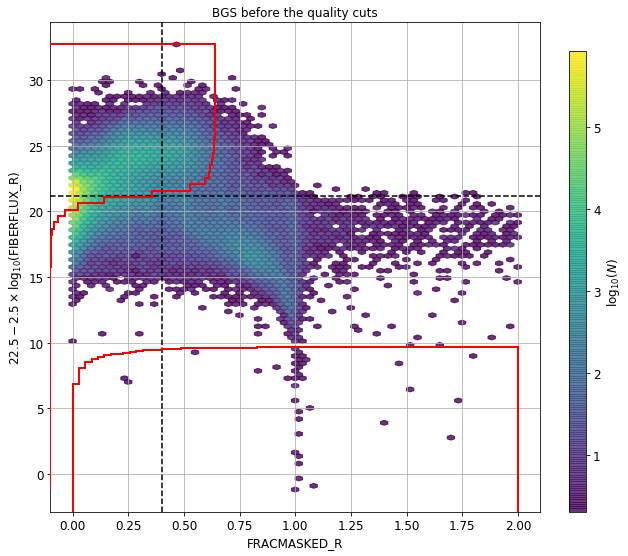

In [489]:
Mask1 = catr['FRACMASKED_R'] < 2
rmagr = flux_to_mag(catr['FLUX_R']/catr['MW_TRANSMISSION_R'])

fiberflux_lite(catr[Mask1], 'FRACMASKED_R', 'FIBERFLUX_R', 1400, 'BGS before the quality cuts', 0.4, 
               fixed=False)

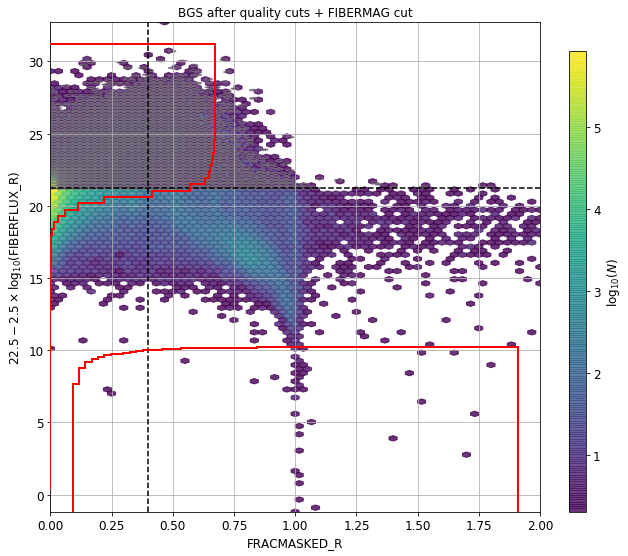

In [495]:

#mask_fiber = (mag2 > 21.2) & (rmagr > 19.5)
#cattmp = catr[Mask1]
#fibmagrT = flux_to_mag(cattmp['FIBERFLUX_R'])
#rmagrT = flux_to_mag(cattmp['FLUX_R']/cattmp['MW_TRANSMISSION_R'])
#mask_fiberT = (fibmagrT > 21.2) & (rmagrT > 19.5)
fiberflux_lite(catr[Mask1], 'FRACMASKED_R', 'FIBERFLUX_R', 1400, 'BGS after quality cuts + FIBERMAG cut', 0.4, 
               fixed=False, shadow=True)
#fiberflux_lite(catr[~mask_fiber], 'FRACMASKED_R', 'FIBERFLUX_R', 1400, 'BGS after quality cuts + FIBERMAG cut', 0.4, fixed=False)

In [498]:
print(len(catr[~qcsMask]), len(cat))

5562915 5562915


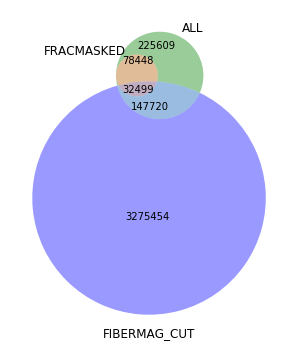

In [508]:
from matplotlib_venn import venn3, venn3_circles

del fibmag, rmag, mask_fiber

fibmag = flux_to_mag(catr['FIBERFLUX_R'])
rmag = flux_to_mag(catr['FLUX_R']/catr['MW_TRANSMISSION_R'])
mask_fiber = (fibmag > 21.2) & (rmag > 19.5)
plt.figure(figsize=(6, 6))

mask11 = ~catr['VETO_FRACMASKED']

venn3([set(catr['RA'][mask11]), set(catr['RA'][qcsMask]), set(catr['RA'][mask_fiber])],
      set_labels = ('FRACMASKED', r'ALL', 'FIBERMAG_CUT'))

## Sumary...

In [531]:
eta_bqc = n_density(catr, 1400)
eta_aqc = n_density(cat, 1400)
eta_aqc_R = n_density(cat[~tyFlag], 1400)

del fibmag, rmag, mask_fiber

fibmag = flux_to_mag(cat['FIBERFLUX_R'])
rmag = flux_to_mag(cat['FLUX_R']/cat['MW_TRANSMISSION_R'])
mask_fiber = (fibmag > 21.2) & (rmag > 19.5) | (tyFlag)

eta_aqc_R_F = n_density(cat[~mask_fiber], 1400)

DONE...
DONE...
DONE...
DONE...


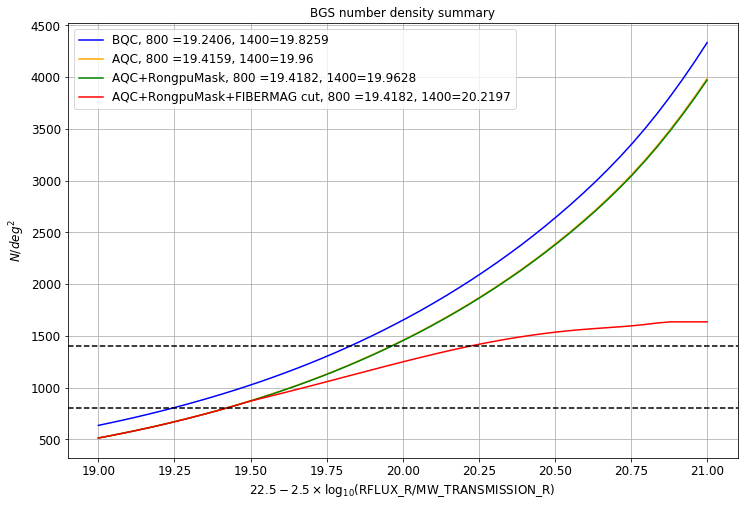

In [535]:
plt.figure(figsize=(12, 8))

# AQC r>19.5
plt.plot(eta_bqc[0], eta_bqc[1], color='blue',label='BQC, 800 =%g, 1400=%g' 
             %(interp(eta_bqc, 800, invert=True), interp(eta_bqc, 1400, invert=True)))

plt.plot(eta_aqc[0], eta_aqc[1], color='orange',label='AQC, 800 =%g, 1400=%g' 
             %(interp(eta_aqc, 800, invert=True), interp(eta_aqc, 1400, invert=True)))

plt.plot(eta_aqc_R[0], eta_aqc_R[1], color='green',label='AQC+RongpuMask, 800 =%g, 1400=%g' 
             %(interp(eta_aqc_R, 800, invert=True), interp(eta_aqc_R, 1400, invert=True)))

plt.plot(eta_aqc_R_F[0], eta_aqc_R_F[1], color='red',label='AQC+RongpuMask+FIBERMAG cut, 800 =%g, 1400=%g' 
             %(interp(eta_aqc_R_F, 800, invert=True), interp(eta_aqc_R_F, 1400, invert=True)))


plt.xlabel(r'$22.5 - 2.5\times \log_{10}$(%s/%s)' %('RFLUX_R', 'MW_TRANSMISSION_R'))
plt.ylabel(r'$N/deg^2$')
plt.title(r'BGS number density summary')
plt.axhline(800, c='k', ls='--')
plt.axhline(1400, c='k', ls='--')
#plt.axhline(700, c='blue', ls='--', label=r'700 sq. deg')
plt.legend()
plt.grid()
plt.show()

## Postage images of FIBERMAG cut...

Getting postage images of rejected objects by the quality cuts between 20 < rmag < 20.1 but excluding objects rejected by BRIGHTSTARINBLOOB.

    qcsMask represent the mask for all the quality cuts
    qcsMask represent the mask for all the quality cuts except the one from BRIGHTSTARINBLOOB

In [549]:
del rmagr
rmagr = flux_to_mag(catr['FLUX_R']/catr['MW_TRANSMISSION_R'])
mask_2 = (qcsMask2) & (rmagr < 20.1) & (rmagr > 19.5)

pixels: 76
pixels: 76


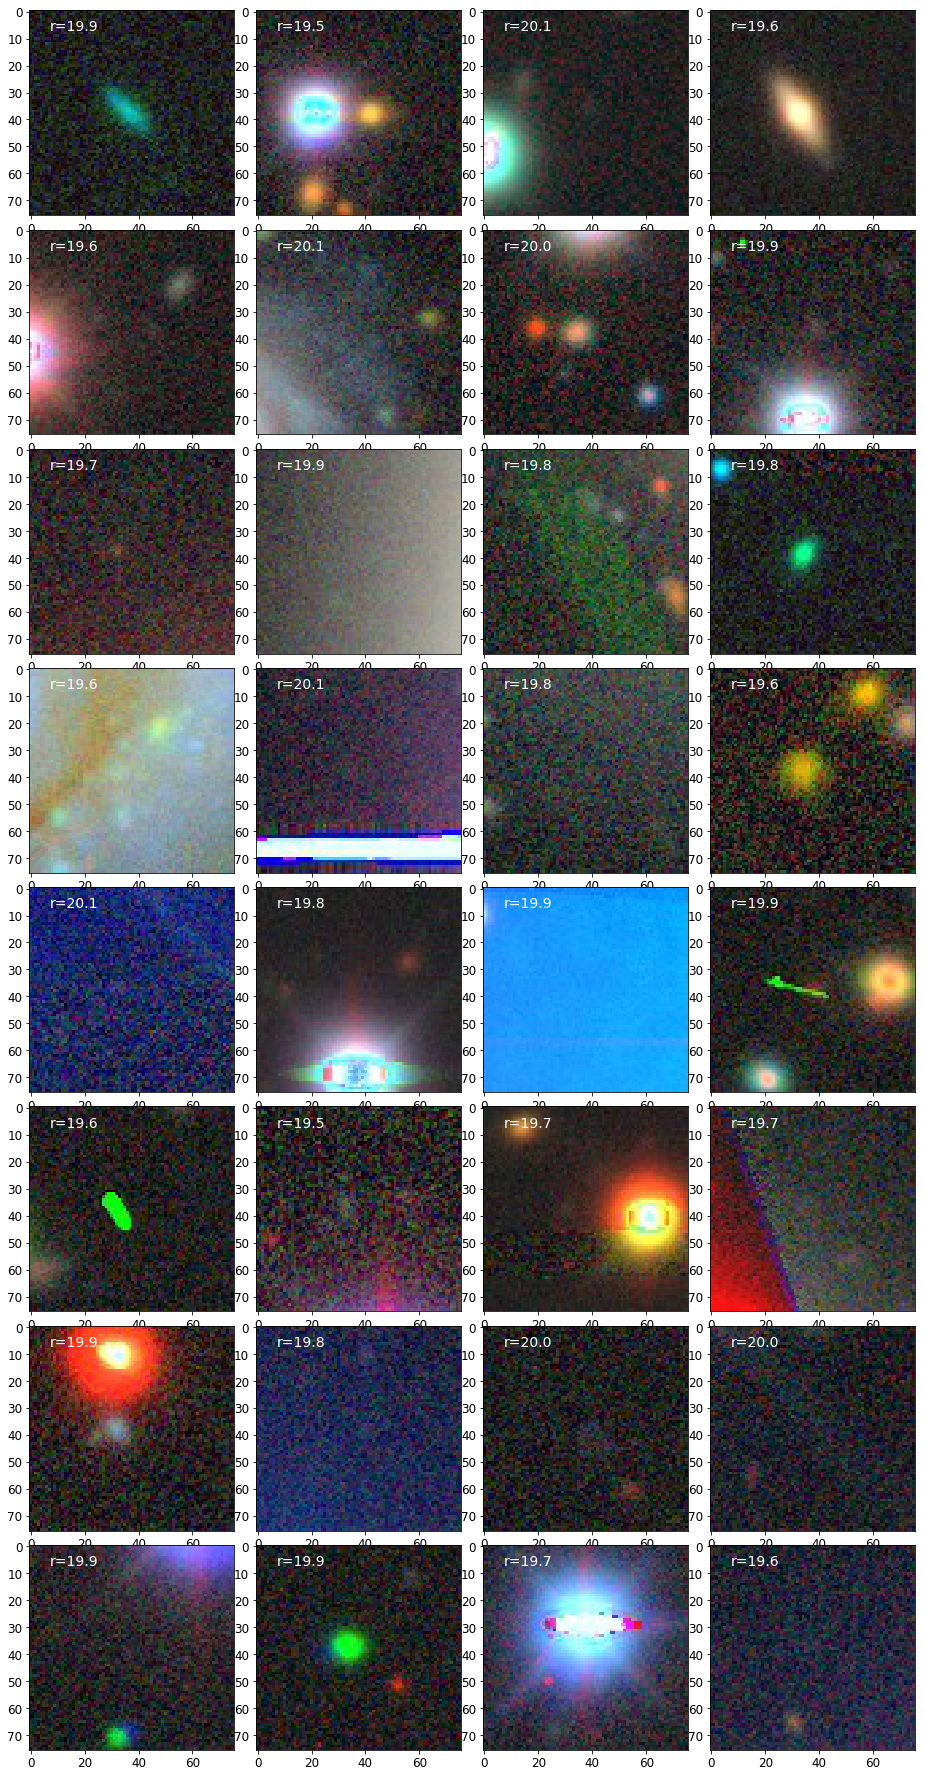

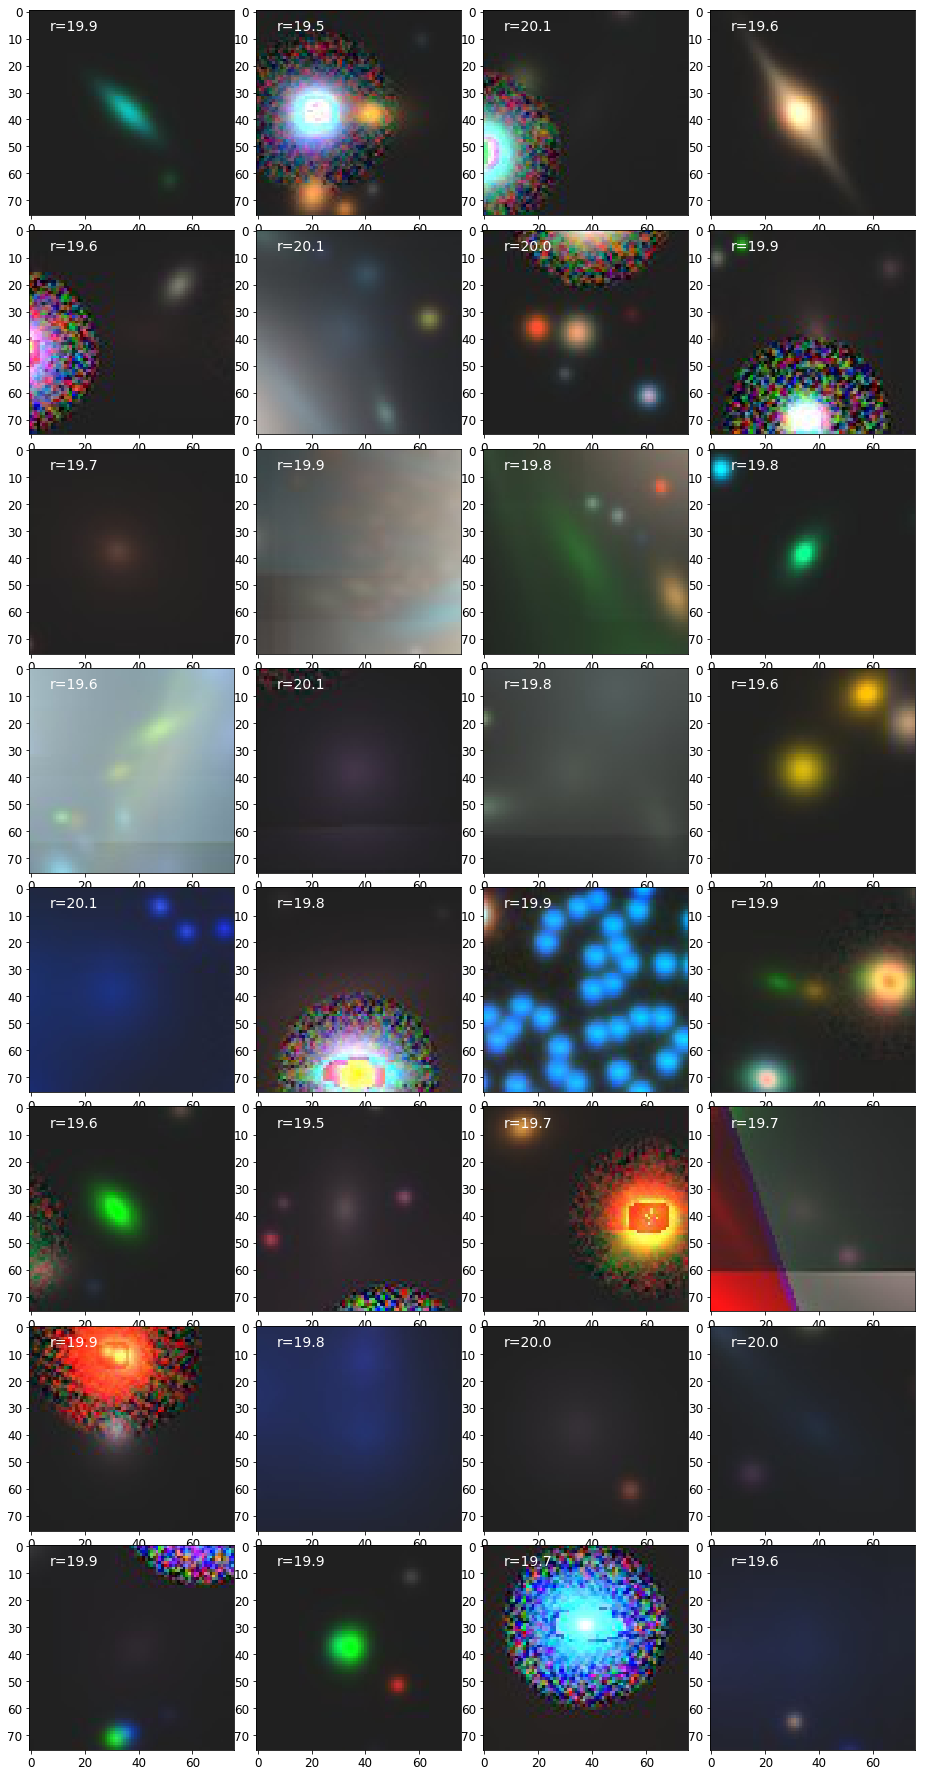

In [550]:
get_postages(catr[mask_2], 8, 4) 

Getting postage images of BGS objects rejected by FIBERMAG cut of 21.2 and rmag > 19.5.

pixels: 76
pixels: 76


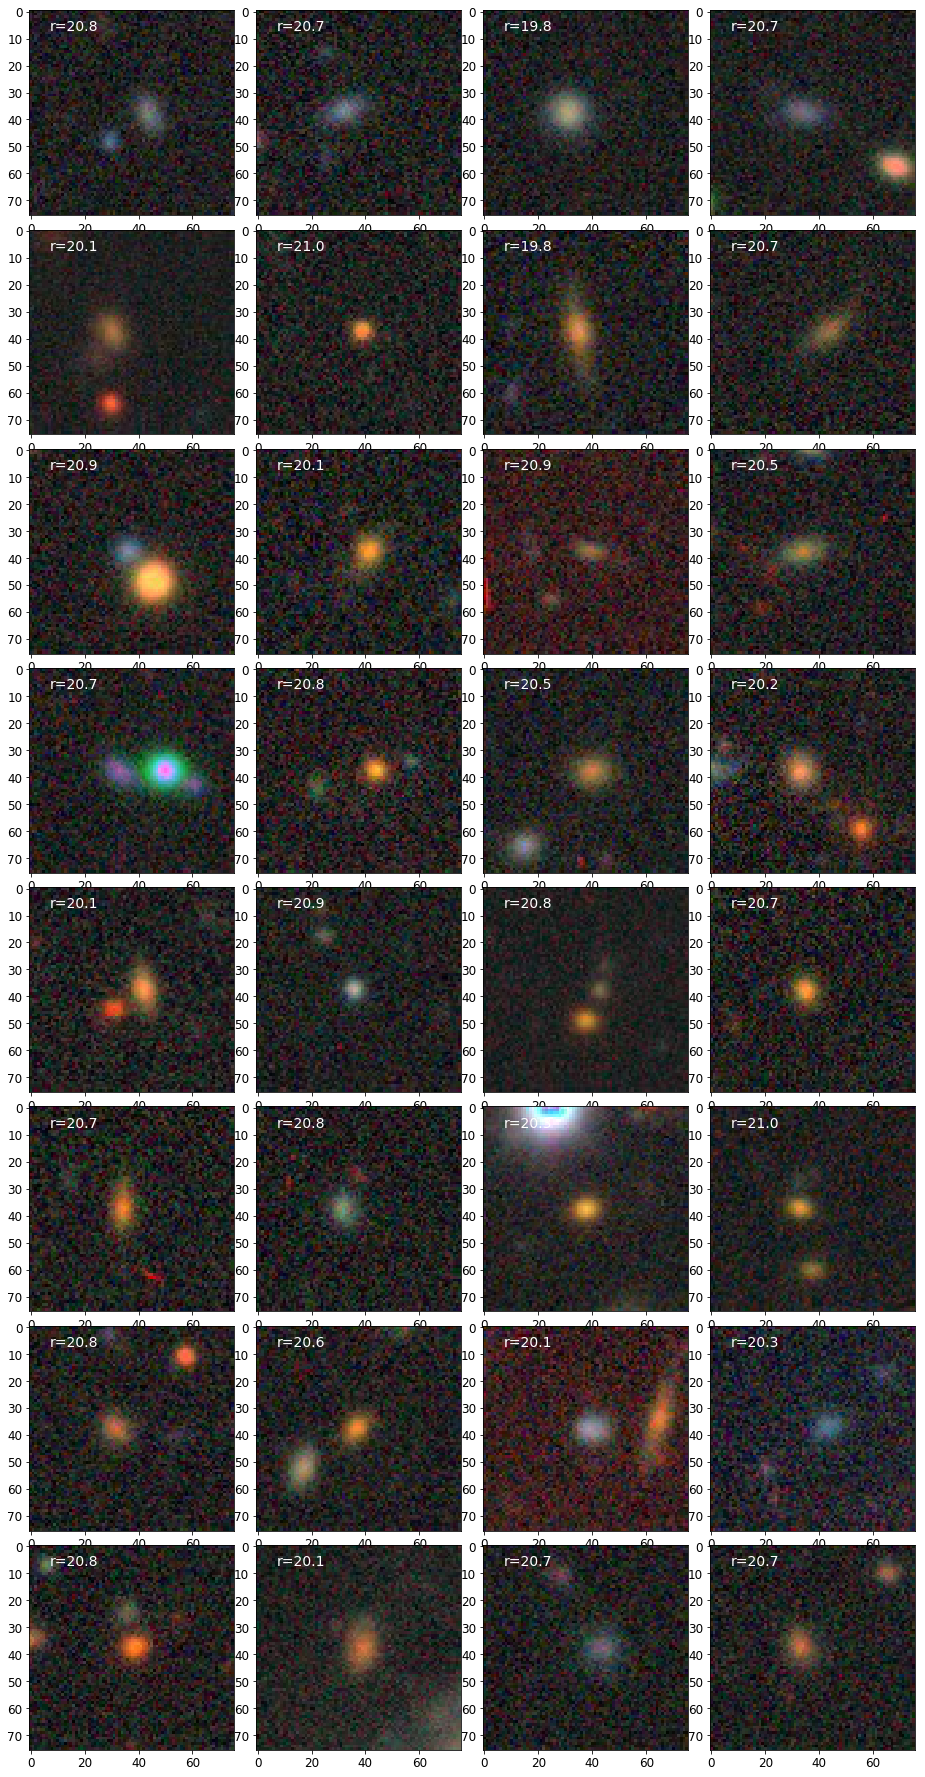

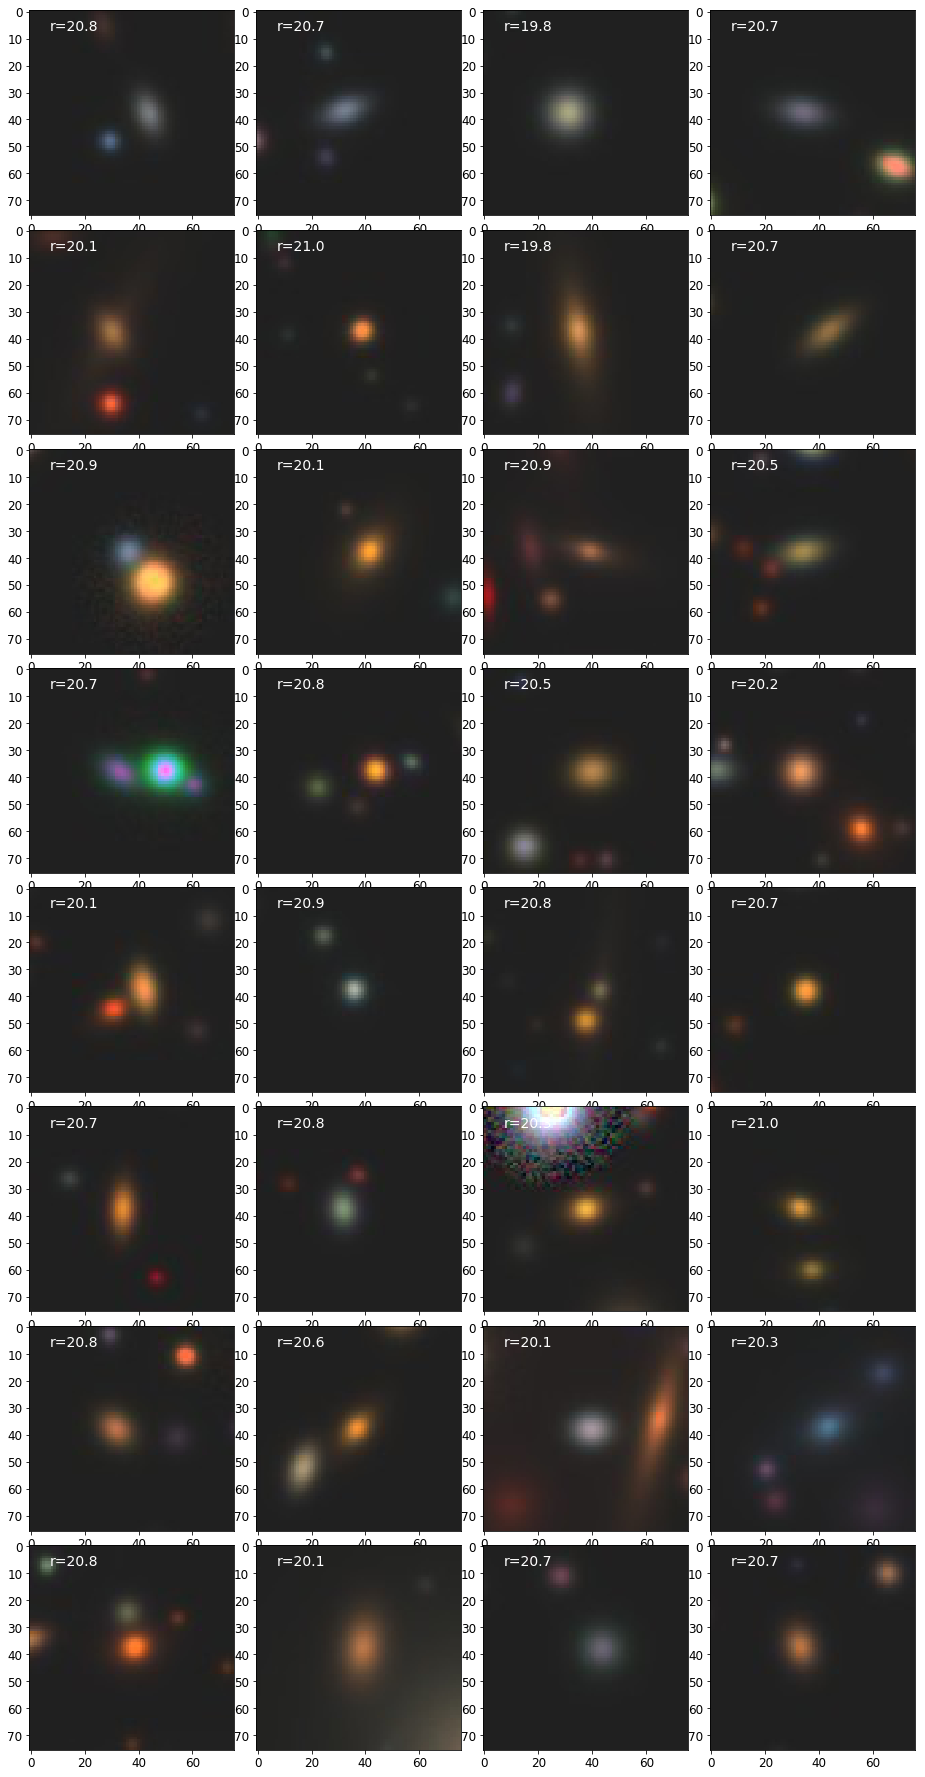

In [555]:
get_postages(cat[(fibmag > 21.2) & (rmag > 19.5)], 8, 4) 

Now, looking at the other side, we select BGS objects below FIBERMAG of 21.2 and rmag > 19.5

pixels: 76
pixels: 76


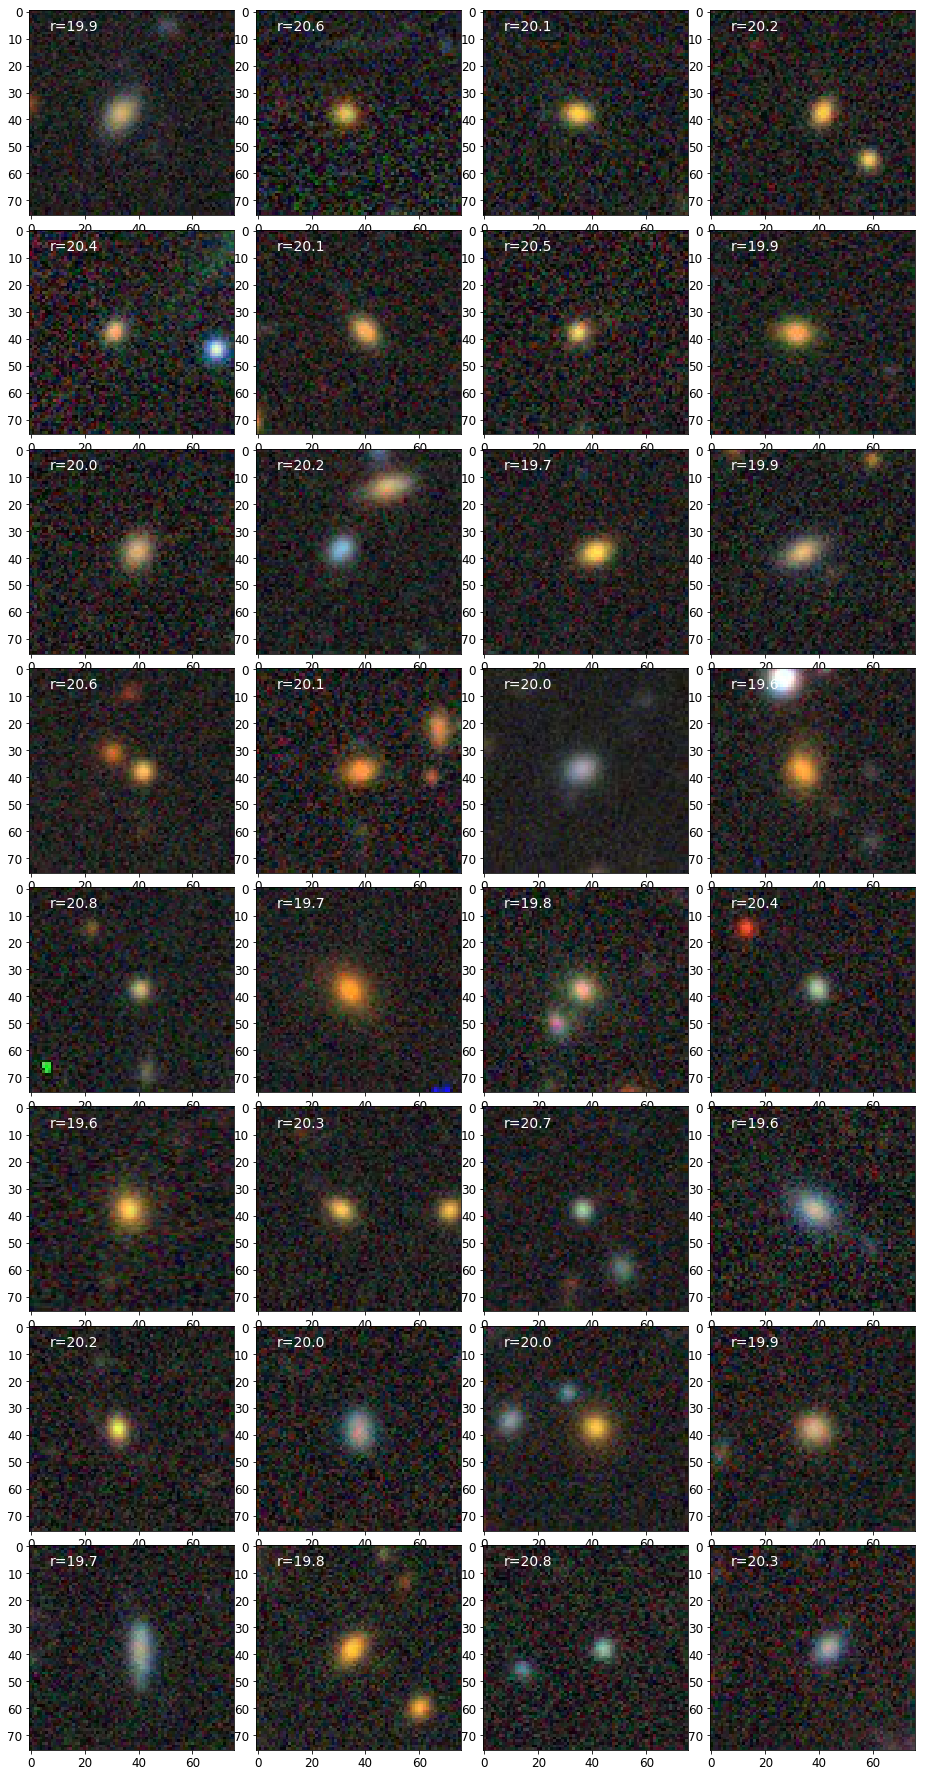

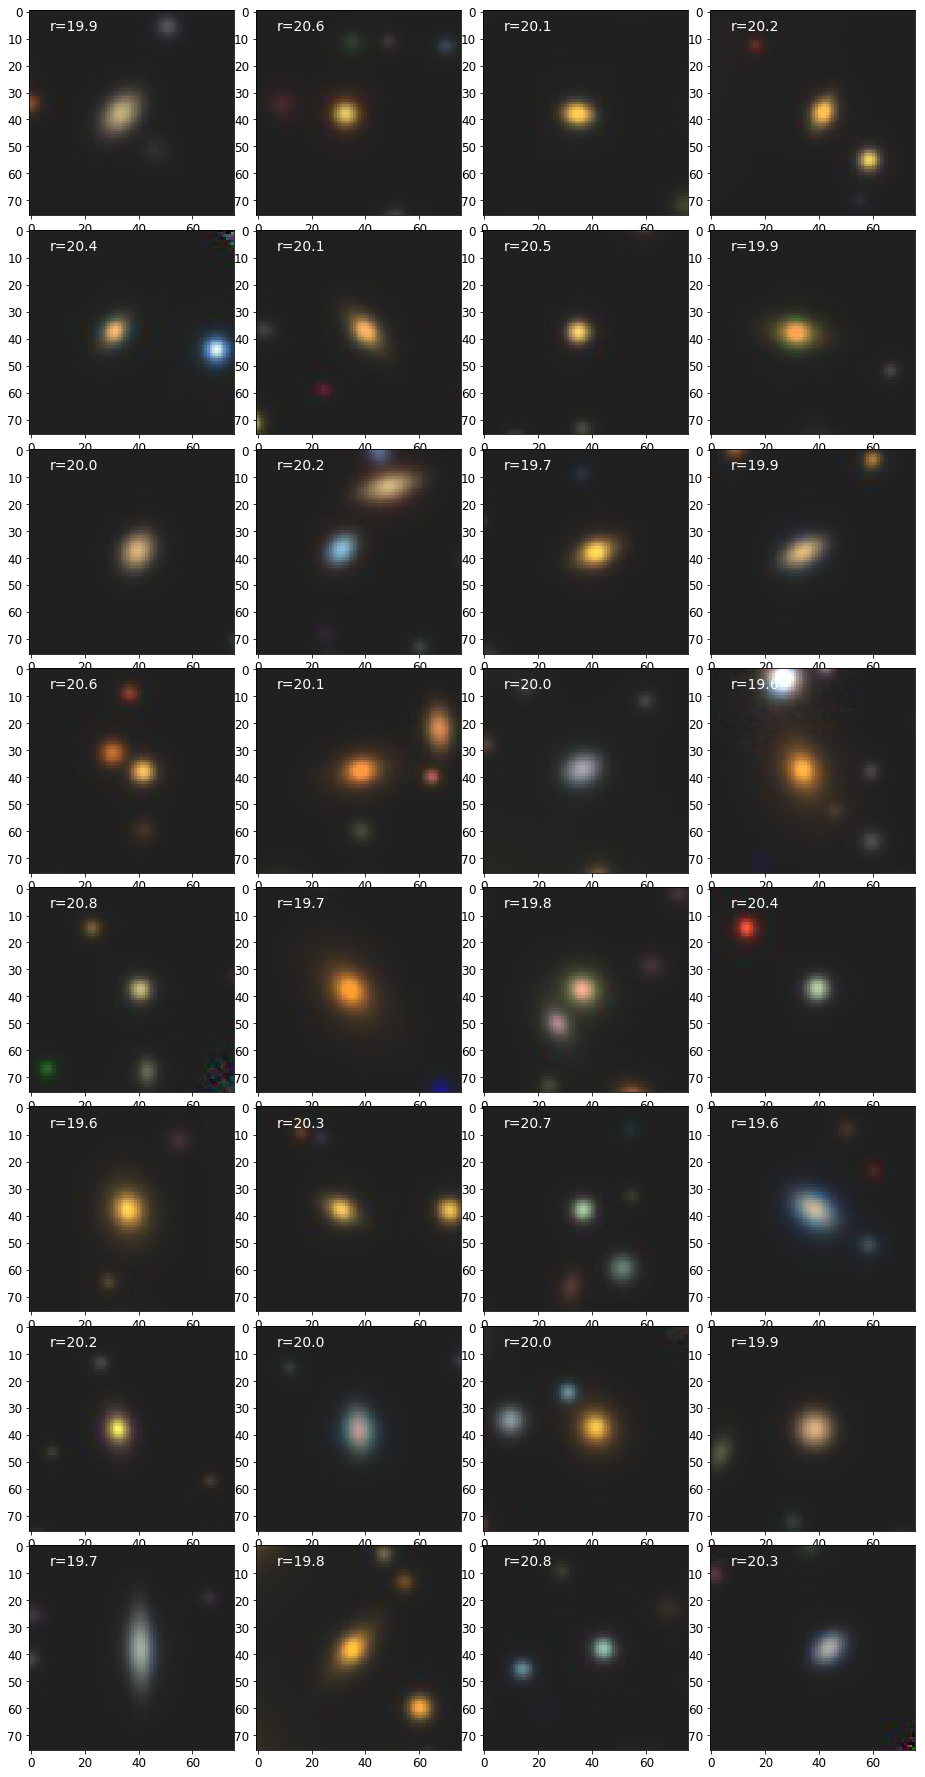

In [558]:
get_postages(cat[(fibmag < 21.2) & (rmag > 19.5)], 8, 4) 

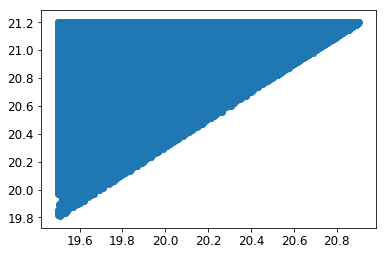

In [557]:
plt.scatter(rmag[(fibmag < 21.2) & (rmag > 19.5)], fibmag[(fibmag < 21.2) & (rmag > 19.5)])

# DEV ZONE

In [81]:
def get_fibmag_cut(cat1):
    
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    fibmag = flux_to_mag(cat1['FIBERFLUX_R'])
    
    mag1 = np.linspace(21, 25, 40)
    mag2 = np.linspace(20, 20.15, 50)
    eta = []
    
    for i in range(len(mag1)):
        
        mask_fiber = fibmag < mag1[i]
        N=0
        
        for j in range(len(mag2)):
            
            N = len(cat1[(mask_fiber) & (rmag < mag2[j])])
            
            if N/1400. >= 600:
                print('fibmag, rmag, density', mag1[i], mag2[j], N/1400.)
                eta.append([mag1[i], mag2[j]])
                
                break
        
    eta = np.array(eta).transpose()
    print('DONE...')
    
    return eta
        

In [82]:
eta_fib = get_fibmag_cut(cat[mask_bgsfaint])

fibmag, rmag, density 21.5 20.1040816327 600.5407142857143
fibmag, rmag, density 22.0 20.0306122449 600.5385714285715
fibmag, rmag, density 22.5 20.0183673469 600.5307142857143
fibmag, rmag, density 23.0 20.0153061224 600.67
fibmag, rmag, density 23.5 20.0153061224 602.6907142857143
fibmag, rmag, density 24.0 20.0153061224 603.9692857142857
fibmag, rmag, density 24.5 20.0153061224 604.5457142857143
fibmag, rmag, density 25.0 20.012244898 600.0921428571429
fibmag, rmag, density 25.5 20.012244898 600.1142857142858
fibmag, rmag, density 26.0 20.012244898 600.1171428571429
DONE...


DONE...
800 p.s.q.d: x = 19.24, y = 20.64
1400 p.s.q.d: x = 19.85, y = 21.17
---------------------
In rmag=19.5: 1008
In rmag=20: 1600
In rmag=20.1: 1793
In rmag=20.2: 2009
In rmag=20.5: 2668


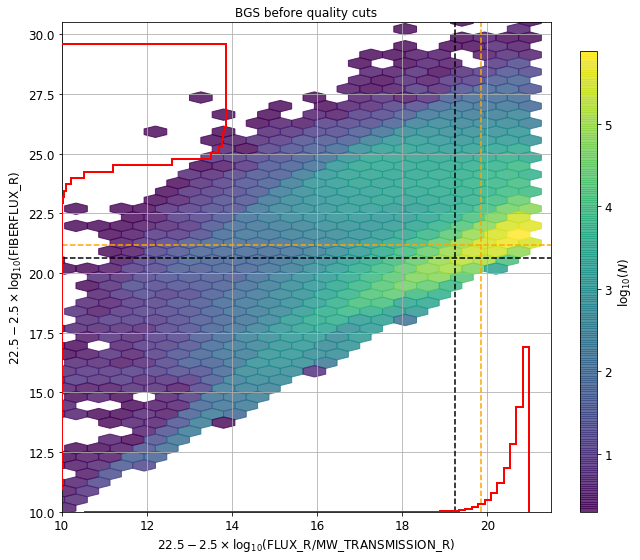

In [100]:
fiberflux(catr, ran, 'FLUX_R', 'FIBERFLUX_R', 1400, 'BGS before quality cuts', fixed=True)

In [537]:
#Extracting the objects rejected by the QCs...
qcs = ['VETO_NOBS','VETO_FRACMASKED','VETO_FRACFLUX','VETO_FRACIN','VETO_FLUX_IVAR','VETO_gr-rz']

#del qcsMask

for i in qcs:
    
    if i == 'VETO_NOBS':
        qcsMask2 = ~catr[i]
        continue
    
    qcsMask2 |= ~catr[i]

DONE...
800 p.s.q.d: x = 21, y = 30.29
1400 p.s.q.d: x = 21, y = 30.29
---------------------
In rmag=19.5: 150.8
In rmag=20: 190.4
In rmag=20.1: 202.5
In rmag=20.2: 215.5
In rmag=20.5: 253.9


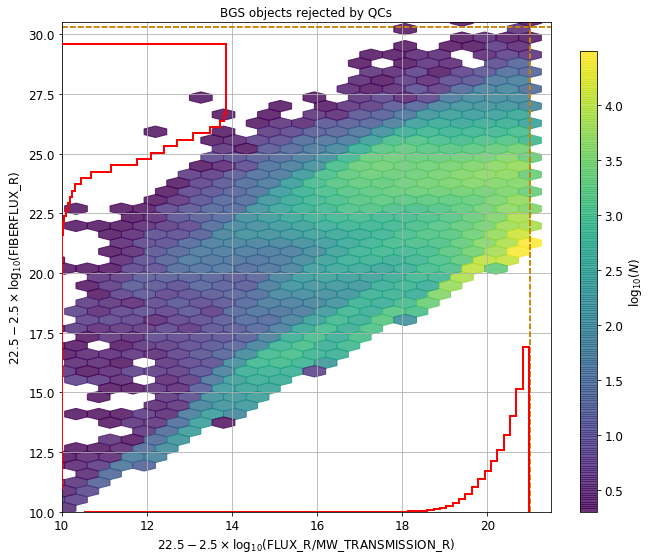

In [102]:
fiberflux(catr[qcsMask], ran, 'FLUX_R', 'FIBERFLUX_R', 1400, 'BGS objects rejected by QCs', fixed=True)